# Gradient descent and neural networks
## Classification of MNIST images

We will look at the MNIST dataset and use NumPy to train a neural network to correctly classify images of handwritten digits.

Steps:
1. explore the MNIST dataset
2. create a class for the layers of a neural network
3. create a neural network with a hidden layer to identify fours
4. train this network with different hyperparameters
5. create and train a deep neural network with 3 hidden layers to classify handwritten digits


## 1. Data import and analysis

In [14]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina' # for better quality plots

# Load the training dataset from MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True)
# Load the test dataset from MNIST
test_data = datasets.MNIST(root='./data', train=False, download=True)

# Converting Data in numpy-Arrays
train_data, train_targets = train_data.data.numpy(), np.array(train_data.targets)
test_data, test_targets = test_data.data.numpy(), np.array(test_data.targets)

# Display the number of images and their size
print("Number of training images:", len(train_data))
print("Number of test images:", len(test_data))
print("Size of an image:", train_data[0].size)
print("Number type:", train_data.dtype)
print("Range of numerical values:", np.min(train_data), np.max(train_data))

Number of training images: 60000
Number of test images: 10000
Size of an image: 784
Number type: uint8
Range of numerical values: 0 255


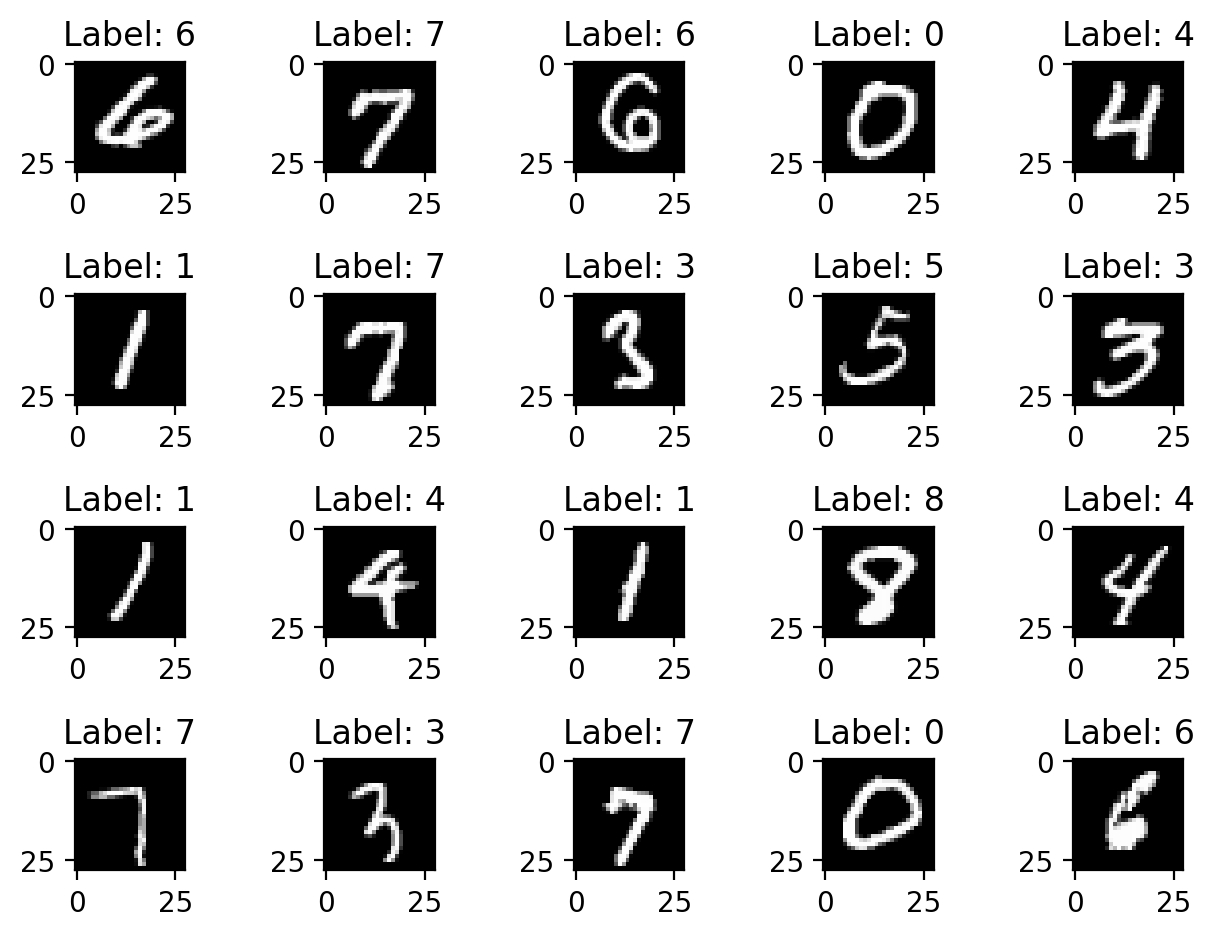

In [15]:
# Show some randomly selected sample images with label
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols)
for i in range(n_rows):
    for j in range(n_cols):
        random_idx = np.random.randint(0, len(train_data) - 1)
        img, label = train_data[random_idx], train_targets[random_idx]
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title("Label: {}".format(label))
plt.tight_layout()
plt.show()

The data set consists of black and white images of handwritten digits, with the label corresponding to the digit shown.
We also look at the frequency of the different labels.

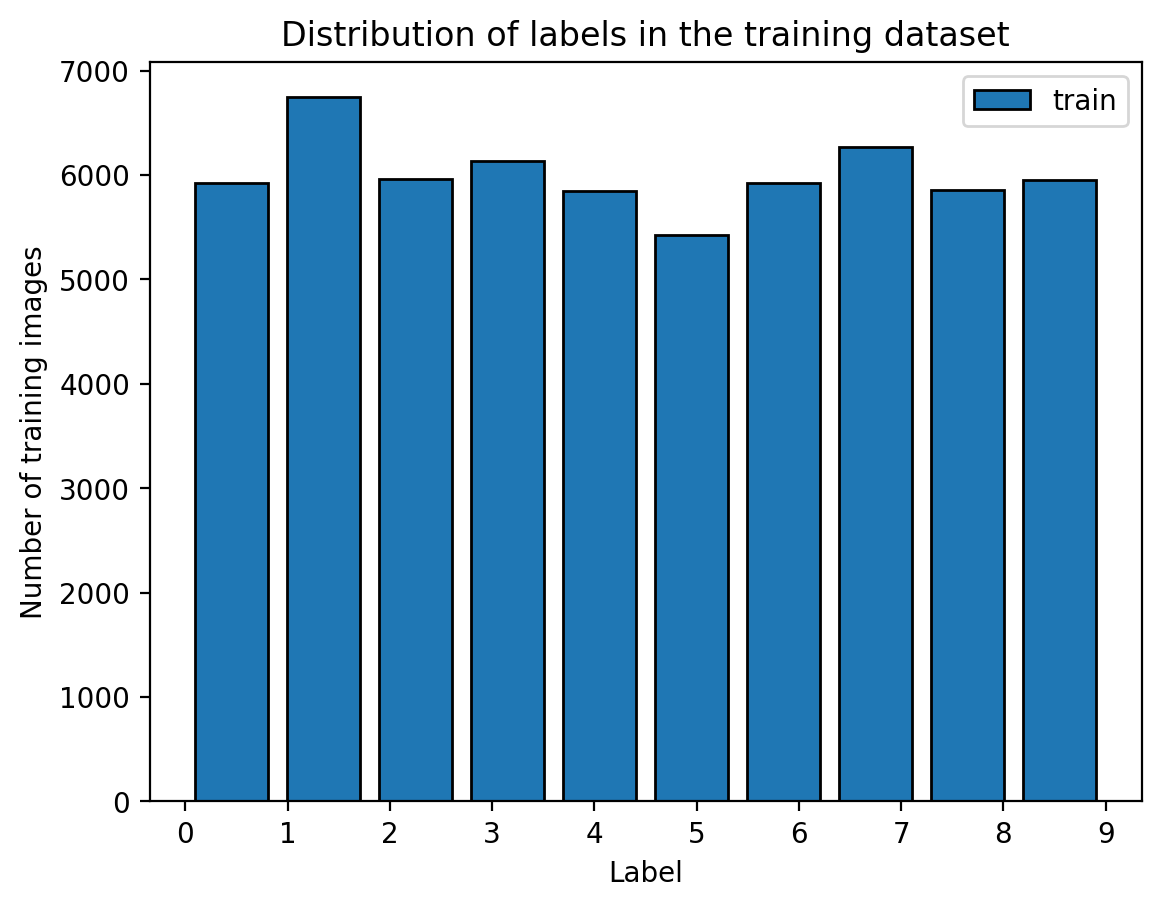

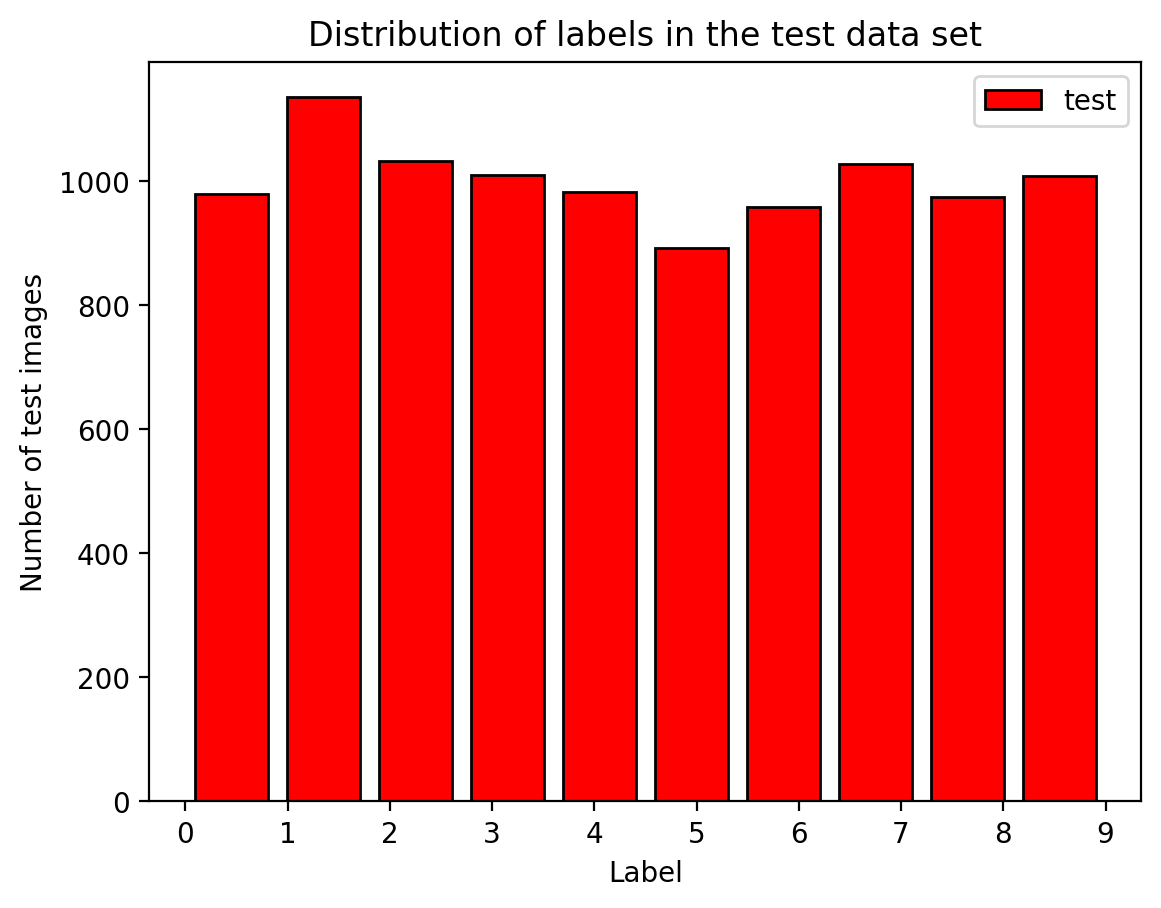

In [50]:
plt.hist(train_targets, bins=10, label="train", edgecolor='black', rwidth=0.8)
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Number of training images')
plt.title('Distribution of labels in the training dataset')
plt.legend()
plt.show()

plt.hist(test_targets, bins=10, label="test", color="r", edgecolor='black', rwidth=0.8)
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Number of test images')
plt.title('Distribution of labels in the test data set')
plt.legend()
plt.show()

**Properties of the data set**
*   **Data set of 70,000 images, 60,000 training, 10,000 test**
*   **Images have 28x28 pixels and one color channel (black\white), i.e. 784 numerical values**
*   **The numerical values are in 8-bit format, stored as integers between 0 and 255**
*   **Each image comes with a label corresponding to the handwritten digits shown**
*   **The distribution of the labels is quite well balanced**

## 2. Linear Layer
Implement a linear layer with numpy.

Input: x: $N$ vectors to $I$ floats ($N \times I$ matrix)

Output: y: $N$ vectors with $O$ floats ($N \times O$ matrix)

A value (node) in the output is calculated by multiplying each input value by an individual weight and adding it up. In addition, each node receives a bias, which is added to this weighted sum to obtain the output.

**Forward step:**
\begin{equation}
y = x \cdot W + b \qquad y_{ij} = \sum_{k=1}^I x_{ik} W_{kj} + b_j
\end{equation}

$\boldsymbol{x} \in \mathbb{R}^{N \times I}$            the input matrix,
$\boldsymbol{W} \in \mathbb{R}^{I \times O}$            the weight matrix,
$\boldsymbol{b} \in \mathbb{R}^{O}$                  the bias vector,
$\boldsymbol{y} \in \mathbb{R}^{N \times O}$            the output matrix.


The output is then used to calculate a loss $\textbf{L}$.
The (negative) derivative of the loss according to the output $\frac{\partial \textbf{L}}{\partial y}$ shows which change in the output leads to a lower loss.
Based on this, the backward step calculates suitable directions to update the weights and biases.
As several linear layers are normally appended to one another, the input of this layer may be the output of another layer. In order to calculate its backward, the previous layer therefore needs the derivative of the loss according to the input of the following layer, here $\frac{\partial \textbf{L}}{\partial x}$.

**Backward step:**
$$\frac{\partial \textbf{L}}{\partial x} = \frac{\partial \textbf{L}}{\partial y} \mathbf{W}^\top \qquad \frac{\partial L}{\partial x_{ik}} = \sum_{j=1}^O \frac{\partial L}{\partial y_{ij}} W_{kj}$$
$$\frac{\partial \textbf{L}}{\partial \mathbf{W}} = x^\top\frac{\partial \textbf{L}}{\partial y} \qquad \frac{\partial L}{\partial W_{kj}} = \sum_{i=1}^N x_{ik} \frac{\partial L}{\partial y_{ij}}
$$
$$\frac{\partial \mathbf{L}}{\partial \mathbf{b}} = \mathbf{1} \frac{\partial \mathbf{L}}{\partial \mathbf{y}}
\qquad \frac{\partial \textbf{L}}{\partial \mathbf{b}} = \sum_{i} \frac{\partial \textbf{L}}{\partial y_i}$$



**Update step:**
\begin{equation}
\mathbf{W} \leftarrow \mathbf{W} - \alpha \frac{\partial L}{\partial \mathbf{W}} \\
\mathbf{b} \leftarrow \mathbf{b} - \alpha \frac{\partial L}{\partial \mathbf{b}}
\end{equation}

The value of the learning rate $\alpha$ is essential. The correct choice depends on many factors and must be determined by trial and error in each individual case.

In [51]:
class LinearLayer:
    def __init__(self, in_dim: int, out_dim: int) -> None:
        """ Initialize the weights randomly using a normal distribution
            with mean 0 and standard deviation 1 and set the bias to 0.
            Initialize instance variables for the inputs, outputs, and gradients."""
        self.weights = np.random.randn(in_dim, out_dim)
        self.weights /= self.weights.sum()  # this makes sure that the forward does not explode at first shot
        self.bias = np.zeros((1, out_dim))
        self.inputs = None
        self.outputs = None
        self.d_weights = None
        self.d_bias = None

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        """ Save the inputs and compute the outputs by multiplying the inputs
            by the weights and adding the bias."""
        self.inputs = inputs
        outputs = np.dot(self.inputs, self.weights) + self.bias
        return outputs  # this is the input for the next layer, after it has been activated

    def backward(self, d_outputs: np.ndarray) -> np.ndarray:
        """ Compute the gradients with respect to the inputs, weights, and bias
            based on the gradient of the loss with respect to the layer's outputs."""
        # d_outputs is dL/dy
        d_inputs = np.dot(d_outputs, self.weights.T) # dL/dx
        self.d_weights = np.dot(self.inputs.T, d_outputs) # dL/dW
        self.d_bias = np.sum(d_outputs, axis=0, keepdims=True)  # dL/db
        return d_inputs  # this is d_outputs for the previous layer

    def update(self, lr: float) -> None:
        """ Update the weights and bias using the gradients and a learning rate."""
        self.weights -= lr * self.d_weights
        self.bias -= lr * self.d_bias

To check whether the code works without errors, we write a few unit tests. These first test whether the outputs have the correct format, which is useful for debugging the code. This is followed by a test that explicitly checks the calculation. It is important that there are at least two values along all axes in order to check the multidimensional implementation correctly.


Explicit calculation:

**With the values**

$$
\text{input }
X = \begin{bmatrix}
1.0 & -1.0 \\
-2.0 & 2.0
\end{bmatrix}
, \qquad
\text{weights }
W = \begin{bmatrix}
2.0 & -2.0 \\
-1.0 & 1.0
\end{bmatrix}
$$

$$
\text{biases }
b = \begin{bmatrix}
1.0 \\
-1.0
\end{bmatrix}
, \qquad
\text{output gradient }
\frac{\partial L}{\partial y} = \begin{bmatrix}
1.0 & -1.0 \\
2.0 & -2.0
\end{bmatrix}
$$

**results in**

$$ \text{output }
Y = \begin{bmatrix}
4.0 & -4.0 \\
-5.0 & 5.0
\end{bmatrix}
$$

**for the forward pass**

**The backward pass for \( x \), \( W \) and \( b \) results in:**

$$
\frac{\partial L}{\partial X} = \begin{bmatrix}
4.0 & -2.0 \\
8.0 & -4.0
\end{bmatrix}
, \qquad
\frac{\partial L}{\partial W}
=
\begin{bmatrix}
-3.0 & 3.0 \\
3.0 & -3.0
\end{bmatrix}
, \qquad
\frac{\partial L}{\partial b}
=
\begin{bmatrix}
3.0 \\
-3.0
\end{bmatrix}
$$

**After applying the update with a learning rate of $\alpha = 0.1$ we get:**

$$
W_{\text{updated}} = \begin{bmatrix}
2.3 & -2.3 \\
-1.3 & 1.3
\end{bmatrix}
, \qquad
b_{\text{updated}} = \begin{bmatrix}
0.7 \\
-0.7
\end{bmatrix}
$$


In [52]:
class TestLinearLayer:
    # First, test shapes. Useful for debugging, but not mandatory
    def test_forward(self):
        # Test the forward pass of the LinearLayer object with two input data points.
        layer = LinearLayer(3, 2)
        inputs = np.random.randn(2, 3)  # Two input data points
        outputs = layer.forward(inputs)
        assert outputs.shape == (2, 2)

    def test_backward(self):
        # Test the backward pass of the LinearLayer object with two input data points and two output gradients.
        layer = LinearLayer(3, 2)
        inputs = np.random.randn(2, 3)  # Two input data points, three dimensions
        layer.forward(inputs)
        d_outputs = np.random.randn(2, 2)  # Two output gradients, two dimensions
        d_inputs = layer.backward(d_outputs)
        assert d_inputs.shape == (2, 3)
        assert layer.d_weights.shape == (3, 2)
        assert layer.d_bias.shape == (1, 2)


    # MANDATORY TEST: test with at least two datapoints   #

    def test_explicitly(self):
        # Initial values
        X = np.array([[1.0, -1.0], [-2.0, 2.0]])
        dO = np.array([[1.0, -1.0], [2.0, -2.0]])
        lr = 0.1

        # Expected values (from previous calculation)
        expected_Y = np.array([[4.0, -4.0], [-5.0, 5.0]])
        expected_dx = np.array([[4.0, -2.0], [8.0, -4.0]])
        expected_dW = np.array([[-3.0, 3.0], [3.0, -3.0]])
        expected_db = np.array([[3.0, -3.0]])
        updated_W = np.array([[2.3, -2.3], [-1.3, 1.3]])
        updated_b = np.array([[0.7, -0.7]])

        # Creation of a LinearLayer object with defined weights and biases
        layer = LinearLayer(2, 2)
        layer.weights = np.array([[2.0, -2.0], [-1.0, 1.0]])
        layer.bias = np.array([[1.0,-1.0]])

        # Forward-Pass test
        Y = layer.forward(X)
        np.testing.assert_almost_equal(Y, expected_Y)

        # Backward-Pass test
        d_inputs = layer.backward(dO)
        np.testing.assert_almost_equal(d_inputs, expected_dx)
        np.testing.assert_almost_equal(layer.d_weights, expected_dW)
        np.testing.assert_almost_equal(layer.d_bias, expected_db)

        # Update test
        layer.update(lr)
        np.testing.assert_almost_equal(layer.weights, updated_W)
        np.testing.assert_almost_equal(layer.bias, updated_b)

test = TestLinearLayer()
test.test_forward()
test.test_backward()
test.test_explicitly()
print("All tests passed!")

All tests passed!


## 3. Neuronal Network

Now we create a neural network with a hidden layer using numpy.
It thus consists of two linear layers: a hidden layer, which takes the image data (input layer), but whose output we do not see. This serves as input for the subsequent output layer, whose output is the prediction. This process is defined in the forward.

In the backward, the derivation for the weights and biases is calculated layer by layer based on the derivation of a loss function after the output. To do this, the same elements as in the forward are now lined up with their backwards in reverse order.
Finally, the model parameters are updated using the derivatives calculated in this way.

For training, the model creates predictions for the classes of all images.
A loss is then calculated by comparing this with the actual classes.
The derivative of this loss is then calculated in the backward pass for all weights and biases and these are updated accordingly.

To evaluate the progress of the function, the *test* function calculates the loss on the given data.

In [53]:
class NeuralNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """Initialize a neural network with given input, hidden and output layer sizes."""
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_layer = LinearLayer(input_size, hidden_size)
        self.hidden_activation = ReLU()
        self.output_layer = LinearLayer(hidden_size, output_size)
        self.output_activation = Sigmoid()

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Perform a forward pass through the neural network given input x."""
        x = self.hidden_layer.forward(x)
        x = self.hidden_activation(x)  # can be any activation function. some activation is required to introduce non-linearity in order to allow the network to learn complicated structures. However, for this dataset the network may work without any activation.
        x = self.output_layer.forward(x)
        x = self.output_activation(x) # mandatory, has to match the target. here sigmoid -> [0,1], target is 0 (not a 4) or 1 (a 4)
        return x

    def backward(self, d_outputs: np.ndarray) -> None:
        """Perform a backward pass through the neural network given derivative of the loss w.r.t output."""
        d = self.output_activation.backward(d_outputs)
        d = self.output_layer.backward(d)
        d = self.hidden_activation.backward(d)
        d = self.hidden_layer.backward(d)

    def update(self, learning_rate: float) -> None:
        """Update the weights of the neural network with the given learning rate."""
        self.hidden_layer.update(learning_rate)
        self.output_layer.update(learning_rate)

    def train(self, inputs: np.ndarray, targets: np.ndarray, learning_rate: float, loss_function) -> float:
        """Train the neural network with the given inputs and targets using the given loss function and learning rate."""
        outputs = self.forward(inputs)
        loss = loss_function(outputs, targets)
        d_outputs = loss_function.derivative(outputs, targets)
        self.backward(d_outputs)
        self.update(learning_rate)
        return loss

    def test(self, inputs: np.ndarray, targets: np.ndarray, loss_function, print_prediction: bool = False) -> float:
        """Test the neural network with the given inputs and targets using the given loss function and return the loss."""
        outputs = self.forward(inputs)
        if print_prediction:
            print("prediction min,max", outputs.min(), outputs.max())
        loss = loss_function(outputs, targets)
        return loss, outputs

class ReLU:
    def __call__(self, x: np.array):
        """Calculates the ReLU function on the input values."""
        self.x = x
        return np.maximum(0, x)

    def backward(self, d_output):
        """Calculates the backward pass of the ReLU function."""
        return (self.x > 0).astype(float) * d_output

class Sigmoid:
    def __call__(self, x: np.array) -> np.ndarray:
        """Computes the sigmoid function on the input values."""
        x_clipped = np.clip(x, -500, 500)   # Limits range of input values to avoid numerical errors
        self.output = 1 / (1 + np.exp(-x_clipped))
        return self.output

    def backward(self, d_output: np.array) -> np.ndarray:
        """Calculates the backward pass of the sigmoid function."""
        sigmoid_derivative = self.output * (1 - self.output)
        return d_output * sigmoid_derivative

**A suitable loss function for a binary classification is the Binary Cross Entropy Loss (BCE).** This loss function is used to measure the difference between the actual probability and the prediction of the model. **The BCE loss is defined as:**

$BCELoss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$

where $y_i$ is the actual label of the ith data point and $\hat{y}_i$ is the prediction of the model. The sum is calculated over all N data points. The BCE loss is minimized if the model makes a perfect prediction (i.e. if $\hat{y}_i = y_i$ for all i), and becomes larger the further $\hat{y}_i$ is from $y_i$. As $y_i$ is always $0$ or $1$, either the left or the right logarithm always applies. Due to the negative sign, the minimization of the loss therefore causes the expression in the logarithm to become 1 if possible and thus pushes $\hat{y}_i$ in the direction of the target.


The Binary Cross Entropy (BCE) loss is a suitable loss function for binary classification problems, as it effectively measures deviations between the actual and predicted probabilities and penalizes large deviations. In contrast, the Mean Squared Error (MSE) loss can be more sensitive to small errors in binary classification problems and lead to slower convergence rates.

The Hinge Loss, which is used in Support Vector Machines, is also an effective loss function for binary classification problems. In contrast to the BCE loss, the hinge loss focuses on optimizing the decision boundary and aims to maximize the distance between classes. It is important to note that the hinge loss does not directly estimate the probabilities, which can be a limitation in certain applications.

To summarize, the BCE loss is a good choice for binary classification problems, while the MSE loss and the hinge loss offer their own advantages. The suitability of the loss functions depends on the specific application and requirements, so none of the loss functions can be considered fundamentally superior.

In [54]:
class BCELoss:
    def __init__(self):
        pass

    def __call__(self, outputs: np.ndarray, targets: np.ndarray, eps: float = 1e-8) -> float:
        """
        Calculate the BCE loss.
        Args:
            outputs (numpy array): The predictions of the model.
            targets (numpy array): The actual labels.
        Returns:
            The value of the BCE loss.
        """
        loss = -np.mean(targets * np.log(outputs + eps) + (1 - targets) * np.log(1 - outputs + eps)) # add small epsilon to prevent log(0)
        return loss

    def derivative(self, outputs: np.ndarray, targets: np.ndarray, eps: float = 1e-8) -> np.ndarray:
        """
        Calculates the derivative of the BCE loss.
        Args:
            outputs (numpy array): The predictions of the model.
            targets (numpy array): The actual labels.
        Returns:
            The derivation of the BCE loss.
        """
        N = outputs.shape[0]
        derivative = 1./N * ((1-targets) / (1-outputs + eps) - targets/(outputs + eps) ) ## add small epsilon to omit division by 0
        return derivative

In [55]:
loss = BCELoss()
N = 16
y = np.random.rand(N,1)
y_hat = np.random.rand(N,1)
loss.derivative(y_hat, y).shape

(16, 1)

The F1-score is a good choice for evaluating the identification of images with the digit 4 in the MNIST dataset because it is a balanced metric that takes into account both Precision (hit rate) and Recall (detection rate). This is important because, when identifying images of the digit 4, both false-positive and false-negative predictions can be problematic.

**The F1-score is defined as:**

\begin{align}
F1\text{-}Score &= \frac{2 \cdot Precision \cdot Recall}{Precision + Recall} \\
Precision &= \frac{\text{True Positives}}{\text{True Positives + False Positives}} \\
Recall &= \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{align}


In contrast to the F1-score, which considers both false-positive and false-negative predictions, accuracy measures the proportion of correct predictions.
Accuracy can be misleading when the classes are imbalanced. Since 90% of the images in the dataset are not a 4, a classifier that always predicts "not a 4" will achieve a high accuracy, even though it does not correctly identify any images of 4s. The F1-score, however, is independent of class distribution and provides a reliable assessment of the classifier's performance.

In [56]:
def precision(tp: int, fp: int) -> float:
    """ Calculates precision from True Positives (tp) and False Positives (fp) """
    if not (tp or fp): return 0  # Verhindere teilen durch 0
    precision = tp / (tp + fp)
    return precision

def recall(tp: int, fn: int) -> float:
    """ Calculates recall from True Positives (tp) and False Negatives (fn) """
    if not (tp or fn): return 0  # Verhindere teilen durch 0
    recall = tp / (tp + fn)
    return recall

def f1_score(tp: int, fp: int, fn: int) -> float:
    """
    Calculates the F1-score from True Positives (tp), False Positives (fp),
    and False Negatives (fn).
    """
    prec = precision(tp, fp)
    rec = recall(tp, fn)
    if not (rec or prec): return 0.  # Prevent division by 0
    f1_score = 2 * prec * rec / (prec + rec)
    return f1_score

def calculate_tp_fp_fn(output: np.ndarray, labels: np.ndarray) -> tuple:
    """Calculates true positives (tp), false positives (fp), and false negatives (fn) for a given neural network model, """
    true_prediction = output > 0.5 # prediction is positive if output is > 0.5
    true_label = labels.astype(bool)
    tp = np.sum(np.logical_and(true_prediction, true_label))
    fp = np.sum(np.logical_and(true_prediction, np.logical_not(true_label)))
    fn = np.sum(np.logical_and(np.logical_not(true_prediction), true_label))
    return tp, fp, fn

def evaluate_f1(outputs: np.ndarray, targets: np.ndarray) -> tuple:
    """Calculates the f1-score, precision and recall"""
    tp, fp, fn = calculate_tp_fp_fn(outputs, targets)
    p = precision(tp, fp)
    r = recall(tp, fn)
    f1 = f1_score(tp, fp, fn)
    return f1, p, r

## 4. Trainieren

Now we will train this neural network to identify images of the digit four from the MNIST dataset. For this, the data needs to be prepared as follows:
* Transform the labels: Convert labels from 0-9 to 1 if the label is 4, and to 0 otherwise.
* Prepare the image data for the linear layer (convert 2D image -> 1D vector).
* Normalize the images to a range of 0-1 to improve performance.

In [57]:
def preprocess_data(images: np.array, label: np.array, target=4) -> tuple:
    """
    Preprocesses image data by: converting images to numpy arrays,
     - reshreshaping data array to linear input vectors
     - normalizing pixel values -> 0-1
     - converting labels to binary classification (1 for label==target, 0 else)
    returns images and labels as tuple
    """
    images = images.reshape(images.shape[0], -1)  # shape: (N,x,y) -> (N,x*y)  ie 28x28 -> 784
    images = images / 255.0  ## rescale to 0-1
    label = np.where(label == target, 1, 0).reshape(-1,1)
    return images, label

**Hyperparameter tuning**
Now we want to train this model with several randomly selected hyperparameters (learning rate, hidden size) and choose the parameters with the best performance. It is also useful to test a grid of hyperparameters.

In [58]:
def train_and_evaluate(num_hyperparams: int, num_epochs: int, print_prediction=False) -> tuple:
    """
    Trains and evaluates a neural network on given train and test data, using a range of hyperparameters.

    Args:
        num_hyperparams (int): Number of different hyperparameters to evaluate the model with.
        num_epochs (int): Number of epochs to train the model for.
        train_data: Data to train the model on.
        test_data: Data to evaluate the trained model on.
        print_prediction (bool, optional): Whether to print predicted labels during testing. Defaults to False.

    Returns:
        tuple: A tuple containing hyperparameters, training losses, testing losses, and testing metrics.
               The first element is a list of dictionaries, where each dictionary contains the hyperparameters for a single model.
               The second and third elements are lists of lists containing the training and testing losses for each epoch of each model.
               The fourth element is a list containing three sub-lists, each of which contains the precision, recall, and F1 score for each epoch of each model, respectively.
    """
    train_losses, train_precisions, train_recalls, train_f1_scores, test_losses, test_precisions, test_recalls, test_f1_scores = [], [], [], [], [], [], [], []
    hyperparameters = []

    train_images, train_labels = preprocess_data(train_data, train_targets)
    test_images, test_labels = preprocess_data(test_data, test_targets)

    for run in range(num_hyperparams):
        learning_rate = 10 ** np.random.uniform(-2, -0)
        hidden_size = np.random.choice([4,8,16])

        input_size = train_images.shape[1]
        output_size = 1

        hp = {
            "lr": learning_rate,
            "n_h": hidden_size,
        }
        hyperparameters.append(hp)
        print(hp)

        model = NeuralNetwork(input_size, hidden_size, output_size)
        loss_function = BCELoss()

        train_loss_history = []
        train_precision_history = []
        train_recall_history = []
        train_f1_history = []
        test_loss_history = []
        test_precision_history = []
        test_recall_history = []
        test_f1_history = []

        # at the very beginning, evaluate the model on both, training and test set, to obtain numbers for the initial state of the model
        train_loss, outputs = model.test(train_images, train_labels, loss_function, print_prediction=print_prediction)
        train_f1, train_precision, train_recall = evaluate_f1(outputs, train_labels)
        test_loss, outputs = model.test(test_images, test_labels, loss_function, print_prediction=print_prediction)
        test_f1, test_precision, test_recall = evaluate_f1(outputs, test_labels)

        train_loss_history.append(train_loss)
        train_precision_history.append(train_precision)
        train_recall_history.append(train_recall)
        train_f1_history.append(train_f1)
        test_loss_history.append(test_loss)
        test_precision_history.append(test_precision)
        test_recall_history.append(test_recall)
        test_f1_history.append(test_f1)


        for epoch in range(num_epochs):
            # first, do the training
            model.train(train_images, train_labels, learning_rate, loss_function)

            # then evaluate the model on both, training and test set, so numbers refer to same state of the model
            train_loss, outputs = model.test(train_images, train_labels, loss_function, print_prediction=print_prediction)
            train_f1, train_precision, train_recall = evaluate_f1(outputs, train_labels)
            test_loss, outputs = model.test(test_images, test_labels, loss_function, print_prediction=print_prediction)
            test_f1, test_precision, test_recall = evaluate_f1(outputs, test_labels)

            train_loss_history.append(train_loss)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)
            test_loss_history.append(test_loss)
            test_precision_history.append(test_precision)
            test_recall_history.append(test_recall)
            test_f1_history.append(test_f1)

        train_losses.append(train_loss_history)
        train_precisions.append(train_precision_history)
        train_recalls.append(train_recall_history)
        train_f1_scores.append(train_f1_history)
        test_losses.append(test_loss_history)
        test_precisions.append(test_precision_history)
        test_recalls.append(test_recall_history)
        test_f1_scores.append(test_f1_history)

    train_metrics = [train_precisions, train_recalls, train_f1_scores]
    test_metrics = [test_precisions, test_recalls, test_f1_scores]
    return hyperparameters, train_losses, train_metrics, test_losses, test_metrics

To easily compare the different runs, we will plot an image for each of the various losses and evaluation metrics, showing the results of all the runs. To view these plots simultaneously, we will combine them into a single figure. The best choice of hyperparameters achieves the lowest test loss and the best evaluation metrics in the fewest number of epochs.

In [59]:
def plot_results(train_losses: list, train_metrics: list, test_losses: list, test_metrics: list, hyperparams: list):
    """ Plots the results of training and evaluating a neural network model with a range of hyperparameters"""
    plt.figure(figsize=(16, 9))

    labels = [f'{", ".join([f"{key}:{val:.3g}" for key,val in hp.items()])}' for hp in hyperparams]


    # Plot train loss for all runs
    plt.subplot(2, 4, 1)
    for train_loss, label in zip(train_losses, labels):
        plt.plot(train_loss, label=label)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot train precision for all runs
    plt.subplot(2, 4, 2)
    for train_metric, label in zip(train_metrics[0], labels):
        plt.plot(train_metric, label=label)
    plt.title('Train Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot train recall for all runs
    plt.subplot(2, 4, 3)
    for train_metric, label in zip(train_metrics[1], labels):
        plt.plot(train_metric, label=label)
    plt.title('Train Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plot train f1 for all runs
    plt.subplot(2, 4, 4)
    for train_metric, label in zip(train_metrics[2], labels):
        plt.plot(train_metric, label=label)
    plt.title('Train F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.legend()

    # Plot test loss for all runs
    plt.subplot(2, 4, 5)
    for test_loss, label in zip(test_losses, labels):
        plt.plot(test_loss, label=label)
    plt.title('Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test precision for all runs
    plt.subplot(2, 4, 6)
    for test_metric, label in zip(test_metrics[0], labels):
        plt.plot(test_metric, label=label)
    plt.title('Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot test recall for all runs
    plt.subplot(2, 4, 7)
    for test_metric, label in zip(test_metrics[1], labels):
        plt.plot(test_metric, label=label)
    plt.title('Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plot test f1 for all runs
    plt.subplot(2, 4, 8)
    for test_metric, label in zip(test_metrics[2], labels):
        plt.plot(test_metric, label=label)
    plt.title('Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [60]:
num_hyperparams = 5
num_epochs = 10

hyperparameters, train_losses, train_metrics, test_losses, test_metrics = \
    train_and_evaluate(num_hyperparams, num_epochs)

{'lr': 0.019536169388742884, 'n_h': 4}
{'lr': 0.1803124031824095, 'n_h': 4}
{'lr': 0.02303614660232317, 'n_h': 16}
{'lr': 0.024136849198999694, 'n_h': 4}
{'lr': 0.015594151156805779, 'n_h': 8}


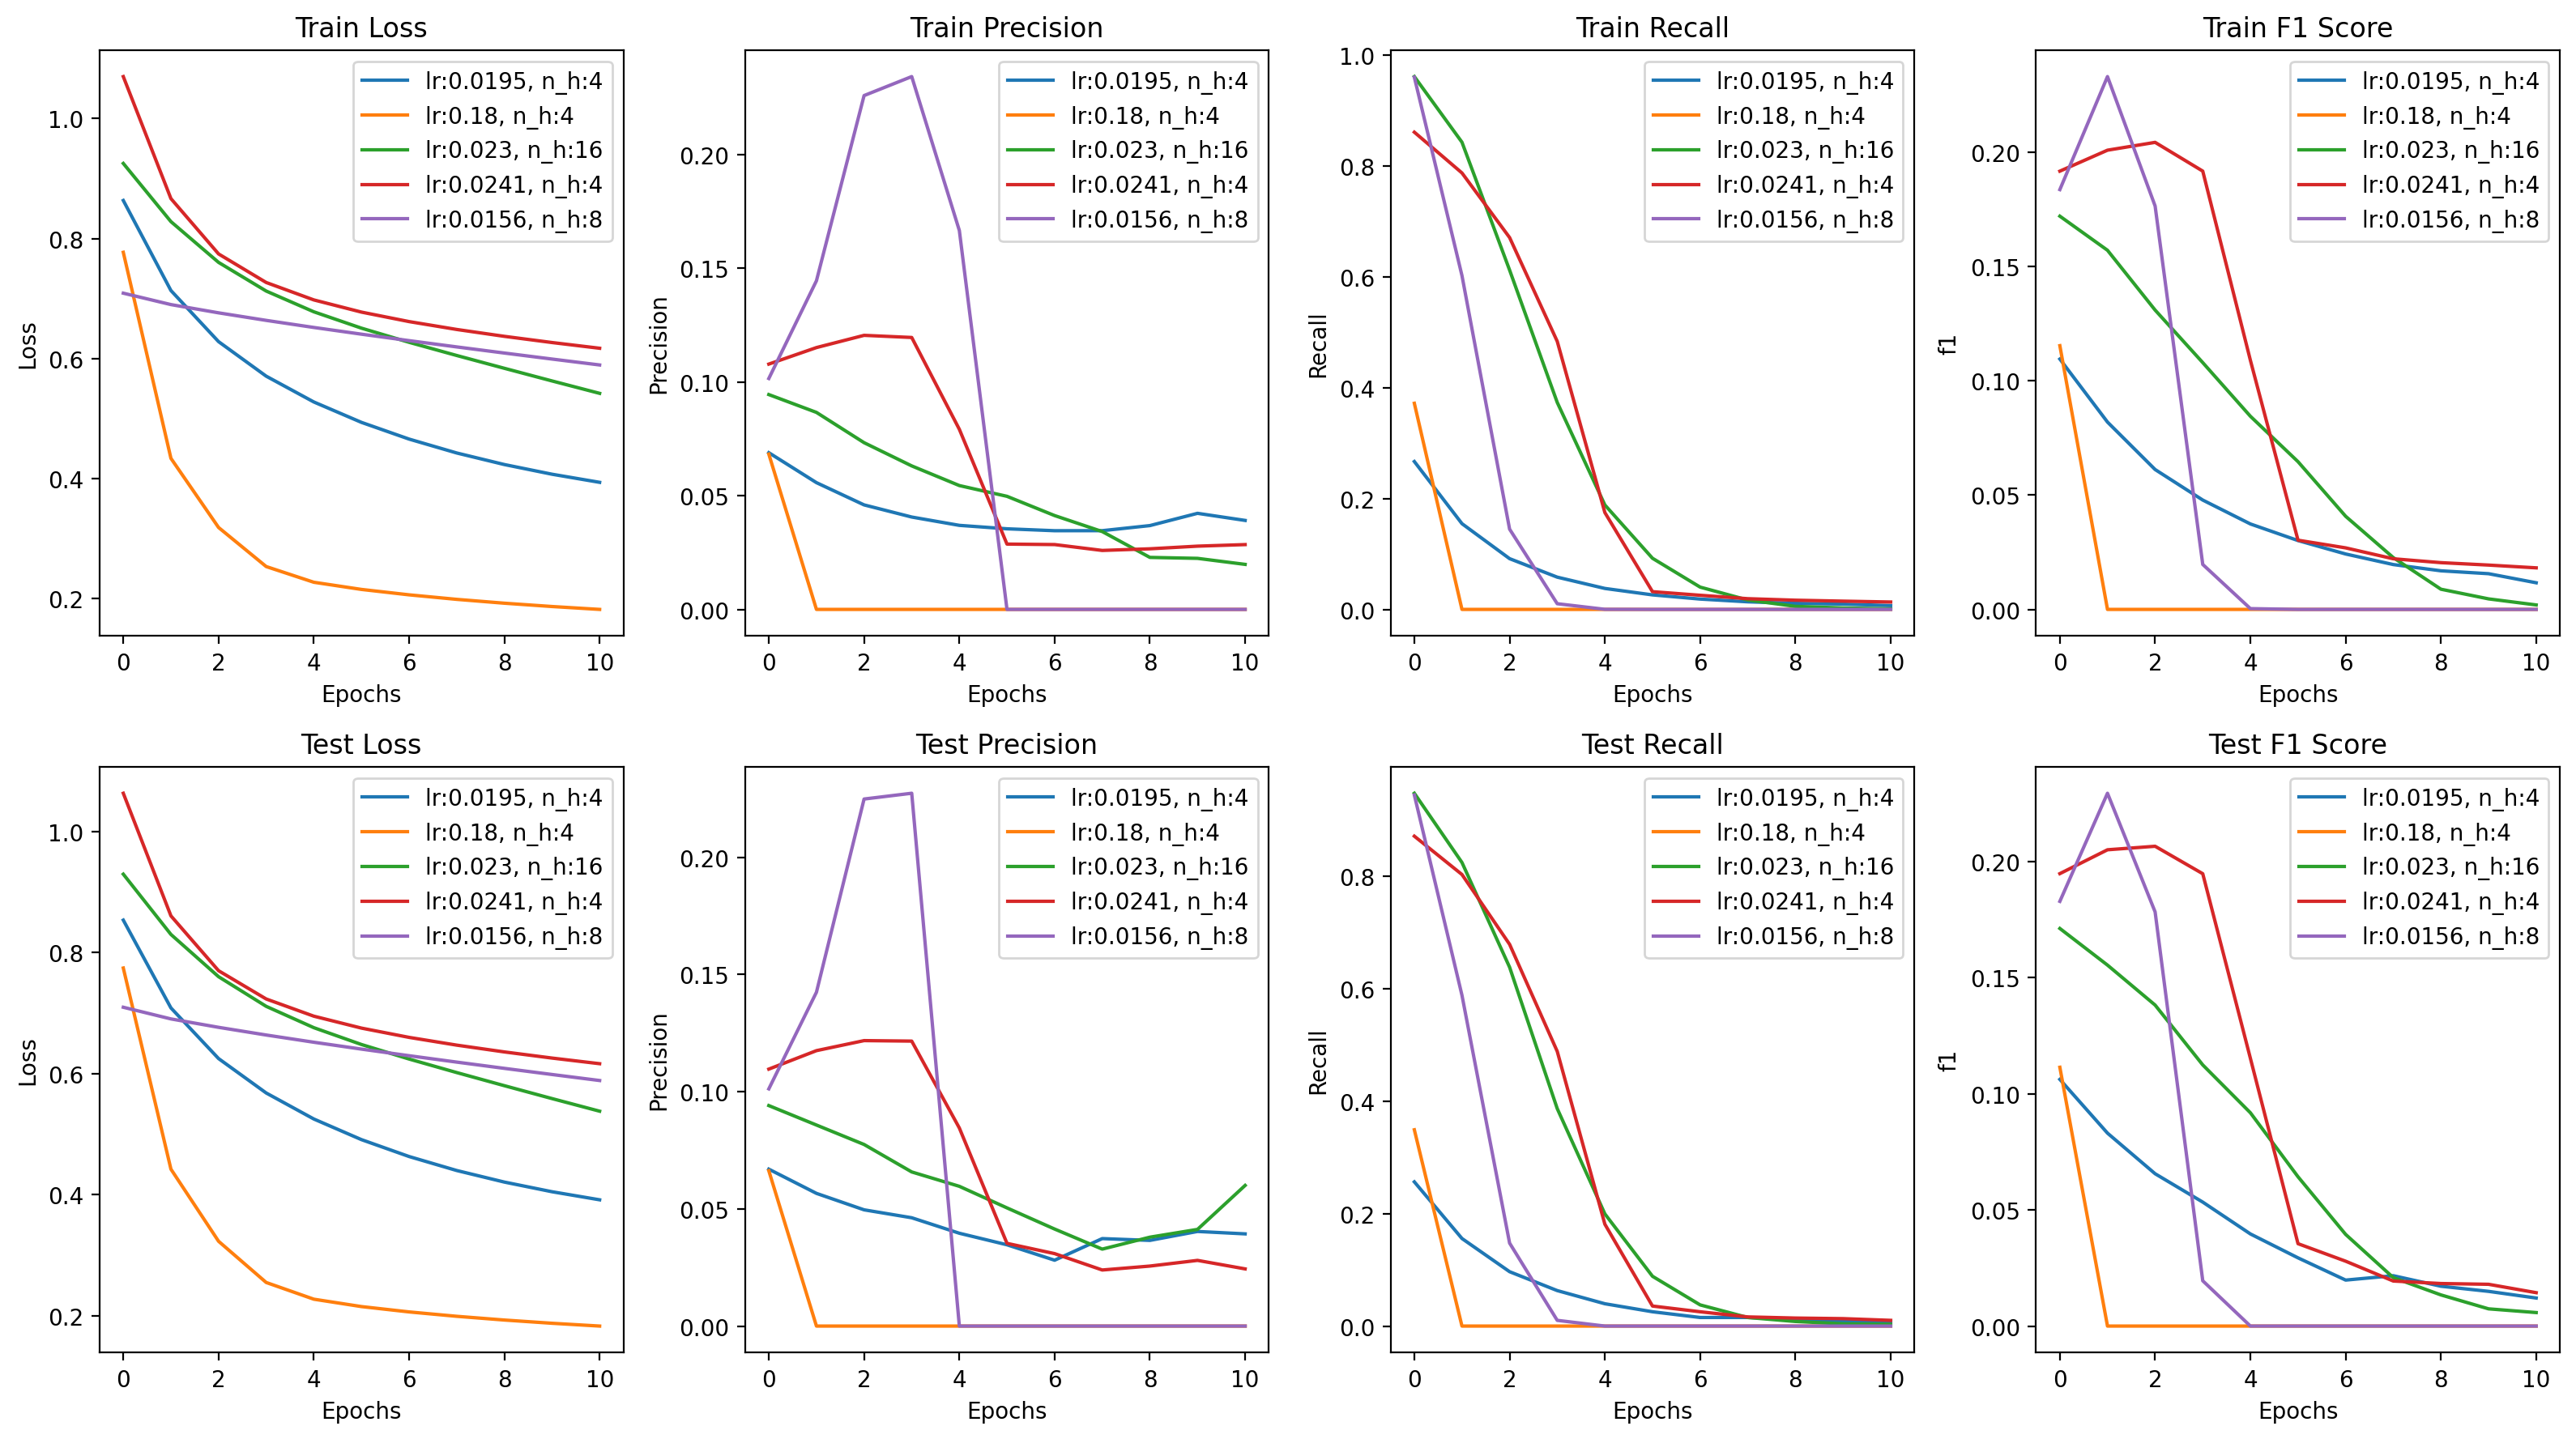

In [61]:
plot_results(train_losses, train_metrics, test_losses, test_metrics, hyperparameters)

**The best choice of hyperparameters is characterized by the best achieved evaluation score, while training and test loss steadily decrease. In this case, Precision, Recall, and F1 should approach as close to 1 as possible.**

However, the plots show stagnating losses and that Precision, Recall, and F1 scores are dropping, almost all going to zero. This means that not a single "4" was correctly identified, even though the training loss has partially improved. We will take another look at the model's output to understand what is happening. To do this, we will plot the minimum and maximum predictions in each epoch.

In [62]:
num_hyperparams = 1
num_epochs = 5

_ = train_and_evaluate(num_hyperparams,
                       num_epochs,
                       print_prediction=True)

{'lr': 0.22602146349332633, 'n_h': 4}
prediction min,max 0.39803869226723715 0.9270033982456128
prediction min,max 0.41786102907485045 0.9319719666661767
prediction min,max 0.20555149165556538 0.4736411872046198
prediction min,max 0.21784554367604914 0.46620582863526955
prediction min,max 0.08462694159191675 0.44813343207363693
prediction min,max 0.10210342382885673 0.4196398782809542
prediction min,max 0.030275629516617202 0.4181950814575917
prediction min,max 0.04257553299396818 0.3782185786978143
prediction min,max 0.013602851225335524 0.3993410731653188
prediction min,max 0.02123611134107729 0.34738284141790005
prediction min,max 0.008239918814769156 0.38884695063119734
prediction min,max 0.013475624260411526 0.32737323844208244


At the beginning, the prediction values still take on values above 0.5, but such values are mostly ruled out after just one computation step.
Thus, the model learns never to recognize a 4, regardless of the input.


**This problem occurs because this simple answer is correct 90% of the time, as only one in ten images shows a 4.** While the gradient from one image aims towards 1, nine other images point towards 0. This imbalance pulls the model down. In other words, the nice minimum we are searching for, where the classification works correctly, is hidden somewhere in the high-dimensional parameter space of the model. Most of the time, however, we find a steep slope in this space, which drives the model straight into the problematic mode we've observed. Since this behavior occurs with all choices of hyperparameters, there is no preferred option.

Had we used normal accuracy (the proportion of correctly classified images) instead of the F1 score, Precision, and Recall, all models would have quickly reached 90%, suggesting a seemingly good model.


**Ways to create balance include, for example:**
* Oversampling the minority class (train 9 times more with images of fours)
* Class weighting (the two classes are weighted according to the imbalance in the loss function):

 9$\times$Loss([4]) + 1$\times$Loss([0,1,2,3,5,6,7,8,9])

as well as other, more advanced methods.

## 5. Deep Network

Now, we are creating a deep network with 3 hidden layers to correctly classify all digits.
This network will decide, for a given image, the probability that it represents each of the 10 digits.
To ensure that the output of the network meets this definition, we will use the softmax activation function:
$$\text{Softmax}(\mathbf{z})_i = S_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$
With this activation, the outputs are strictly positive, normalized to sum to 1, and thus represent a probability distribution.

The partial derivative of the softmax function is:

$$
\frac{\partial}{\partial z_k} S_i = S_i \left(\delta_{ik} - S_k\right)
$$

In [63]:
class DeepNetwork:
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        Initializes a 'deep' neural network with three hidden layers
        far a specified input size, hidden size (number of nodes), and output size.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_layer1 = LinearLayer(input_size, hidden_size)
        self.relu1 = ReLU()
        self.hidden_layer2 = LinearLayer(hidden_size, hidden_size)
        self.relu2 = ReLU()
        self.hidden_layer3 = LinearLayer(hidden_size, hidden_size)
        self.relu3 = ReLU()
        self.output_layer = LinearLayer(hidden_size, output_size)
        self.softmax = Softmax()

    def __call__(self, x): # allows to call forward using model(x) instead of model.forward(x)
        return self.forward(x)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Performs a forward pass through all layers of the deep neural network."""
        x = self.hidden_layer1.forward(x)
        x = self.relu1(x)
        x = self.hidden_layer2.forward(x)
        x = self.relu2(x)
        x = self.hidden_layer3.forward(x)
        x = self.relu3(x)
        x = self.output_layer.forward(x)
        x = self.softmax(x)  # has to match the target. here we output the probability for every class
        return x

    def backward(self, d_outputs: np.ndarray) -> None:
        """Performs a backward pass through all layors of the deep neural network."""
        d = self.softmax.backward(d_outputs)
        d = self.output_layer.backward(d)
        d = self.relu3.backward(d)
        d = self.hidden_layer3.backward(d)
        d = self.relu2.backward(d)
        d = self.hidden_layer2.backward(d)
        d = self.relu1.backward(d)
        d = self.hidden_layer1.backward(d)

    def update(self, learning_rate: float) -> None:
        """Updates all weights and biases with gradients computed with backward."""
        self.hidden_layer1.update(learning_rate)
        self.hidden_layer2.update(learning_rate)
        self.hidden_layer3.update(learning_rate)
        self.output_layer.update(learning_rate)


class Softmax:
    def __call__(self, x: np.ndarray) -> np.ndarray:
        """ Computes softmax on first axis of x. output in [0,1], sum = 1 along axis 1 """
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract the maximum value for numerical stability (equivalent to shortening the fraction)
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, d_output: np.ndarray) -> np.ndarray:
        """ Computes the backward call """
        dim = self.output.shape[1]
        delta = np.eye(dim)
        S = self.output
        dsoftmax = S[:, :, None] * (delta[None, :, :] - S[:, None, :])
        return np.einsum('ij,ijk->ik', d_output, dsoftmax)


This dummy test is useful for debugging the code. The loss should decrease monotonically, and the output should adjust to match the target.

In [64]:
input_size = 1
output_size = 2
hidden_size = 4
lr = 0.5
N = 2

target = np.array([[0,1],[1,0]]).reshape(output_size,N)
inp = np.array([[0],[1]])
#inp = np.random.randn(N, input_size)
#target = np.random.randn(N, output_size)

print("target", target.shape, "\n", target)

np.random.seed(75)

network = DeepNetwork(input_size, hidden_size, output_size)
"""
norm = 0.001
network.hidden_layer1.weights /= norm
network.hidden_layer2.weights /= norm
network.hidden_layer3.weights /= norm
network.output_layer.weights /= norm
"""
for i in range(15):
    out = network(inp)
    loss = np.mean((out - target)**2)
    print("out",list(list(np.round(o,4)) for o in out), "loss", loss)
    d_loss = 2*(out - target) / N

    network.backward(d_loss)
    network.update(lr)

target (2, 2) 
 [[0 1]
 [1 0]]
out [[0.5, 0.5], [0.4785, 0.5215]] loss 0.26098556852074994
out [[0.503, 0.497], [0.4977, 0.5023]] loss 0.2526479945888435
out [[0.5031, 0.4969], [0.5068, 0.4932]] loss 0.24819153910864622
out [[0.5021, 0.4979], [0.514, 0.486]] loss 0.24416540706644793
out [[0.5006, 0.4994], [0.523, 0.477]] loss 0.2390275234899698
out [[0.4976, 0.5024], [0.5366, 0.4634]] loss 0.2311814599922271
out [[0.4931, 0.5069], [0.5585, 0.4415]] loss 0.2190382441717057
out [[0.4856, 0.5144], [0.5938, 0.4062]] loss 0.2003974158751211
out [[0.4727, 0.5273], [0.6361, 0.3639]] loss 0.17794458328901247
out [[0.4829, 0.5171], [0.7288, 0.2712]] loss 0.15334841827114712
out [[0.4239, 0.5761], [0.7368, 0.2632]] loss 0.12445243278043164
out [[0.4225, 0.5775], [0.8367, 0.1633]] loss 0.10261081318242174
out [[0.3596, 0.6404], [0.8252, 0.1748]] loss 0.07994295057243887
out [[0.3464, 0.6536], [0.8893, 0.1107]] loss 0.06613127355722742
out [[0.3044, 0.6956], [0.8367, 0.1633]] loss 0.05966773819549

**For the classification of MNIST images, the Cross-Entropy Loss (CE) is suitable, as it directly optimizes the probability distribution of the classes. It is defined as:**

\begin{equation}
CELoss = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \log(p_{i,j})
\end{equation}

Here, $N$ represents the number of examples in the dataset, $C$ is the number of classes, $y_{i,j}$  is an indicator of whether the $i$-te example belongs to class $j$ (1 if yes, 0 otherwise), and $p_{i,j}$ is the predicted probability by the model that the $i$-te example belongs to class $j$.

The Cross-Entropy Loss calculates the negative logarithm of the predicted probability for the correct class ($y_{i,j}=1$) The loss becomes zero when all these probabilities are equal to 1 and increases as these probabilities decrease. Since the sum of probabilities for an image is 1, increasing the probabilities for the correct class simultaneously decreases the probabilities for incorrect classes. Therefore, no additional term is needed, as with Binary Cross-Entropy (BCE).

For MNIST classification, Cross-Entropy Loss (CE) is a better choice than Mean Squared Error (MSE) because the goal is to obtain a probability distribution over all classes. CE directly optimizes the probability distribution, whereas MSE minimizes the difference between the actual and predicted numbers. Since predictions are often incorrect, MSE tends to decrease all probabilities. As a result, MSE struggles to handle many classes and would take much longer for the model to converge.

Additionally, the derivative of MSE is always less than 1, since both the prediction and target values lie between 0 and 1. In contrast, CE computes the quotient of the values, so the magnitude of the derivative is always greater than 1. This increases the gradient value and hence the step size during updates. However, this difference can be compensated for in MSE by using a higher learning rate.


In [65]:
class CrossEntropyLoss:
    def __init__(self):
        self.softmax_output = None
        self.targets = None

    def __call__(self, predictions, targets):
        return self.forward(predictions, targets)

    def forward(self, predictions: np.ndarray, targets: np.ndarray, eps=1e-8) -> float:
        """Calculates the cross-entropy loss.
        Assumes prediction is one-hot-encoded, while targets are integers showing the correct class"""
        self.targets = targets
        self.predictions = predictions
        N = predictions.shape[0]
        loss = -np.log(predictions[range(N),targets] + eps) # add small number to omit log(0)
        loss = np.mean(loss)
        return loss

    def derivative(self, eps=1e-8) -> np.ndarray:
        """Calculates the derivative of the cross-entropy loss."""
        N = self.predictions.shape[0]
        d_softmax = np.zeros(self.predictions.shape)
        d_softmax[range(N), self.targets] =  - 1./(self.predictions[range(N), self.targets] + eps)
        return d_softmax


The data is prepared according to the task.
This time, we use the unchanged integer labels.

In [66]:
def preprocess_data(images: np.array, label: np.array) -> tuple:
    """Preprocesses the input data for a neural network model.
    The preprocessing steps include:
     - reshaping the images to the appropriate shape for a linear layer,
     - normalizing the pixel values to be between 0 and 1,
     - transposing the image array to fit the assumed shape = (N_pixels, N_batch).
    Label stay as they are.
    """
    images = images.reshape(images.shape[0], -1)  ## 28x28 -> 784
    images = images / 255.0 ## data range -> 0-1
    return images, label

**Since the distribution of the classes is well-balanced (i.e., each digit appears roughly equally often), the accuracy score, which measures the proportion of correct classifications, is suitable for this problem:**
\begin{equation}
Accuracy = \frac{\text{True Positive} + \text{True Negative}}{\text{Alle}}
=  \frac{1}{N} \sum_{i=1}^N (y_i = \hat{y_i})
\end{equation}

Accuracy is a simple and intuitive metric that indicates the percentage of correctly classified examples relative to the total number of examples. When the classes are balanced, accuracy is a reliable indicator of the classifier's overall performance.

On the other hand, F1, Precision, and Recall are more specific metrics that are especially useful in situations where the costs of false positive and false negative predictions differ. However, these metrics can give uneven results in cases with balanced classes, as they focus on specific classes and do not reflect the classifier's overall performance.

To determine which predictions a classifier gets right and wrong in multi-class classification problems, using a confusion matrix is a helpful approach. The confusion matrix is a table, similar to True/False Positives/Negatives, that shows how often each class is predicted correctly or incorrectly and with which class it is frequently confused.


In [67]:
def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the accuracy score (amount of correctly classified images)"""
    # Compute the ratio of correctly predicted labels
    return np.mean(y_true == y_pred)

def plot_confusion_matrix(predictions: np.ndarray, labels: np.ndarray, class_names: list = list(range(10))) -> None:
    """
    Plot a confusion matrix using the given one-hot encoded predictions and target labels.
    """
    # Get the number of classes
    num_classes = len(class_names)

    # Initialize the confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)

    # Fill the confusion matrix
    predicted_label = np.argmax(predictions, axis=1)
    for t, p in zip(labels, predicted_label):
        cm[t][p] += 1

    # If class names are not provided, use default names
    if class_names is None:
        class_names = ['Class {}'.format(i) for i in range(num_classes)]

    # Plot confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

The training process remains fundamentally the same, but the model, labels, and loss function have been adjusted accordingly. Once again, we perform multiple runs with random parameters and select the model with the best performance.

In [68]:
def train_network(num_trainings: int=5, epochs: int=5, print_predictions=False) -> tuple:
    """
    Trains a deep neural network using stochastic gradient descent with cross-entropy loss.
    
    Args:
    - num_trainings (int): The number of trainings to run. Default: 5.
    - epochs (int): The number of epochs to train each network. Default: 5.
    - train_data: The training data. Default: None.
    - test_data: The test data. Default: None.

    Returns:
    - tuple: A tuple containing the labels, train losses, test losses, and test accuracies for each training run.
    """
    output_size = 10 # Number of classes

    train_images, train_labels = preprocess_data(train_data, train_targets)
    test_images, test_labels = preprocess_data(test_data, test_targets)

    all_labels = []
    all_train_losses = []
    all_test_losses = []
    all_test_accuracies = []
    for i in range(num_trainings):
        # Hyperparameters
        hidden_size = np.random.choice([4,8,16])
        learning_rate = 10.**np.random.uniform(-2, 0)
        label = f"lr={learning_rate:.2g}, n_h={hidden_size}"
        print(label)

        # setup model and loss function
        input_size = train_images.shape[1]
        network = DeepNetwork(input_size, hidden_size, output_size)
        loss_function = CrossEntropyLoss()

        # Trainings-Loop
        train_losses = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):

            # compute test loss before training, such that results for an epoch refer to the same state of the model
            test_predictions = network.forward(test_images)
            test_loss = loss_function(test_predictions, test_labels)
            test_losses.append(test_loss)
            if epoch == epochs-1:
                plot_confusion_matrix(test_predictions, test_labels)
            if print_predictions:
                print("prediction", np.round(test_predictions[:2],2))
            test_predictions = np.argmax(test_predictions, axis=1)  # convert one-hot-encoded predictions to class labels
            test_accuracy = accuracy_score(test_labels, test_predictions)
            test_accuracies.append(test_accuracy)


            # Forward-Pass
            predictions = network.forward(train_images)

            # compute train loss
            loss = loss_function(predictions, train_labels)
            train_losses.append(loss)

            # Backward-Pass
            d_outputs = loss_function.derivative()
            network.backward(d_outputs)

            # update parameters (weights and biases)
            network.update(learning_rate)

            print(f'Training {i+1}/{num_trainings}, Epoch {epoch + 1}/{epochs}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

        all_labels.append(label)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)
    return all_labels, all_train_losses, all_test_losses, all_test_accuracies

In [69]:
def plot_results(labels: list[str], train_losses: list[list[float]], test_losses: list[list[float]], test_accuracies: list[list[float]]):
    """
    Plots the train and test losses and accuracy scores for multiple training runs.
    """
    # Plot train and test losses and accuracy scores for all runs
    plt.figure(figsize=(10, 4))

    # Plot train losses
    plt.subplot(1, 2, 1)
    for label, train_loss in zip(labels, train_losses):
        plt.plot(train_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()

    # Plot test losses
    plt.subplot(1, 2, 2)
    for label, test_loss in zip(labels, test_losses):
        plt.plot(test_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot test accuracies
    plt.figure(figsize=(5, 4))
    for label, test_accuracy in zip(labels, test_accuracies):
        plt.plot(test_accuracy, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

lr=0.37, n_h=4
Training 1/5, Epoch 1/5, Train Loss: 2.3397, Test Loss: 2.3387, Test Accuracy: 0.0642
Training 1/5, Epoch 2/5, Train Loss: 16.6038, Test Loss: 16.6560, Test Accuracy: 0.0958
Training 1/5, Epoch 3/5, Train Loss: 16.6038, Test Loss: 16.6560, Test Accuracy: 0.0958
Training 1/5, Epoch 4/5, Train Loss: 16.6038, Test Loss: 16.6560, Test Accuracy: 0.0958


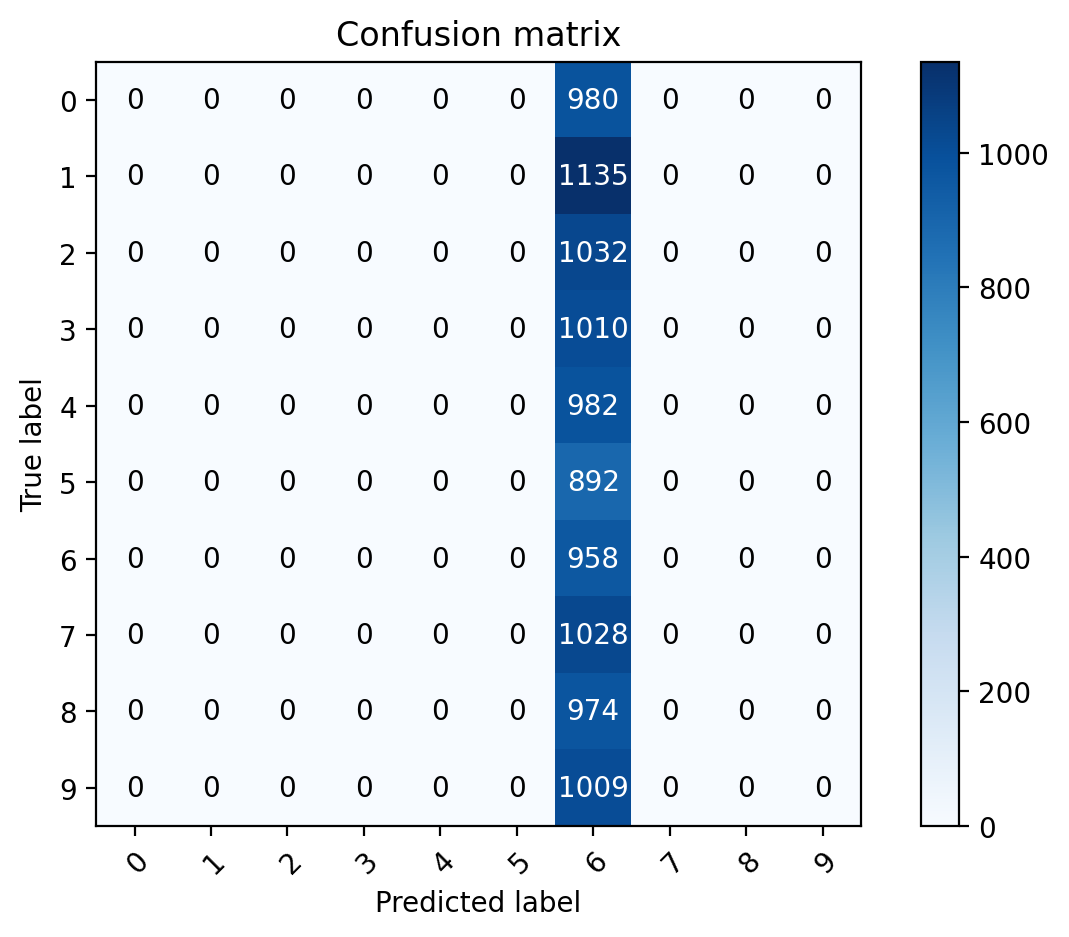

Training 1/5, Epoch 5/5, Train Loss: 16.6038, Test Loss: 16.6560, Test Accuracy: 0.0958
lr=0.089, n_h=16
Training 2/5, Epoch 1/5, Train Loss: 2.3025, Test Loss: 2.3025, Test Accuracy: 0.1094
Training 2/5, Epoch 2/5, Train Loss: 16.6244, Test Loss: 16.6265, Test Accuracy: 0.0974
Training 2/5, Epoch 3/5, Train Loss: 16.6244, Test Loss: 16.6265, Test Accuracy: 0.0974
Training 2/5, Epoch 4/5, Train Loss: 16.6244, Test Loss: 16.6265, Test Accuracy: 0.0974


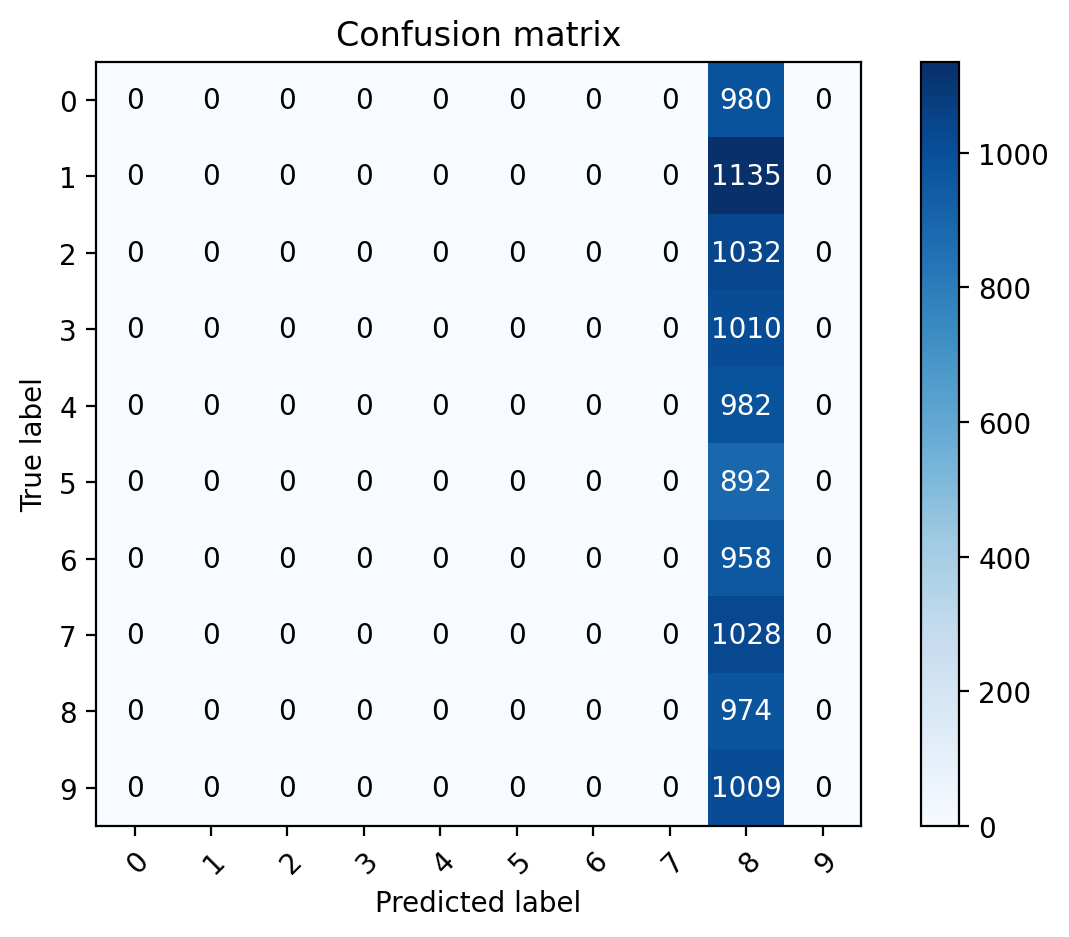

Training 2/5, Epoch 5/5, Train Loss: 16.6244, Test Loss: 16.6265, Test Accuracy: 0.0974
lr=0.029, n_h=4
Training 3/5, Epoch 1/5, Train Loss: 2.3027, Test Loss: 2.3030, Test Accuracy: 0.1049
Training 3/5, Epoch 2/5, Train Loss: 16.7564, Test Loss: 16.7776, Test Accuracy: 0.0892
Training 3/5, Epoch 3/5, Train Loss: 16.7564, Test Loss: 16.7776, Test Accuracy: 0.0892
Training 3/5, Epoch 4/5, Train Loss: 16.7564, Test Loss: 16.7776, Test Accuracy: 0.0892


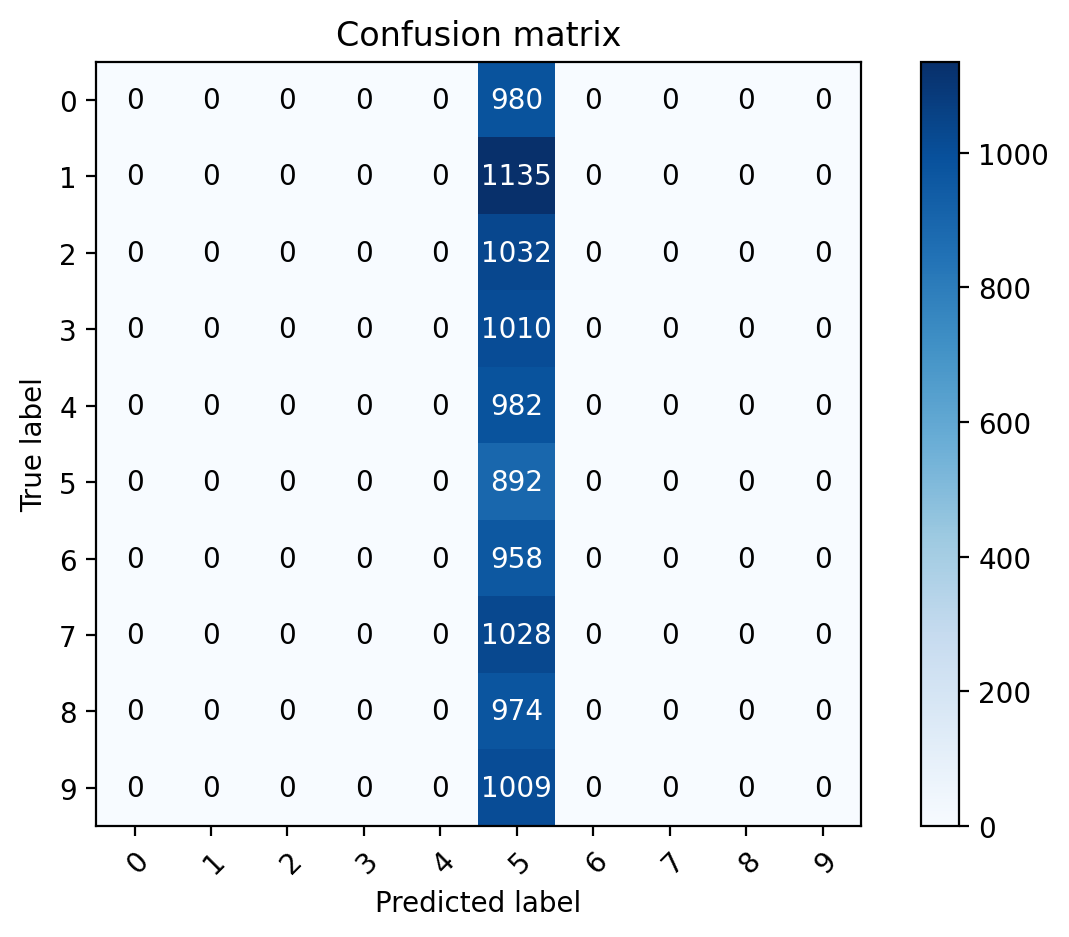

Training 3/5, Epoch 5/5, Train Loss: 16.7564, Test Loss: 16.7776, Test Accuracy: 0.0892
lr=0.72, n_h=16
Training 4/5, Epoch 1/5, Train Loss: 2.3026, Test Loss: 2.3025, Test Accuracy: 0.1284
Training 4/5, Epoch 2/5, Train Loss: 15.6263, Test Loss: 15.6392, Test Accuracy: 0.1510
Training 4/5, Epoch 3/5, Train Loss: 15.6263, Test Loss: 15.6392, Test Accuracy: 0.1510
Training 4/5, Epoch 4/5, Train Loss: 15.6263, Test Loss: 15.6392, Test Accuracy: 0.1510


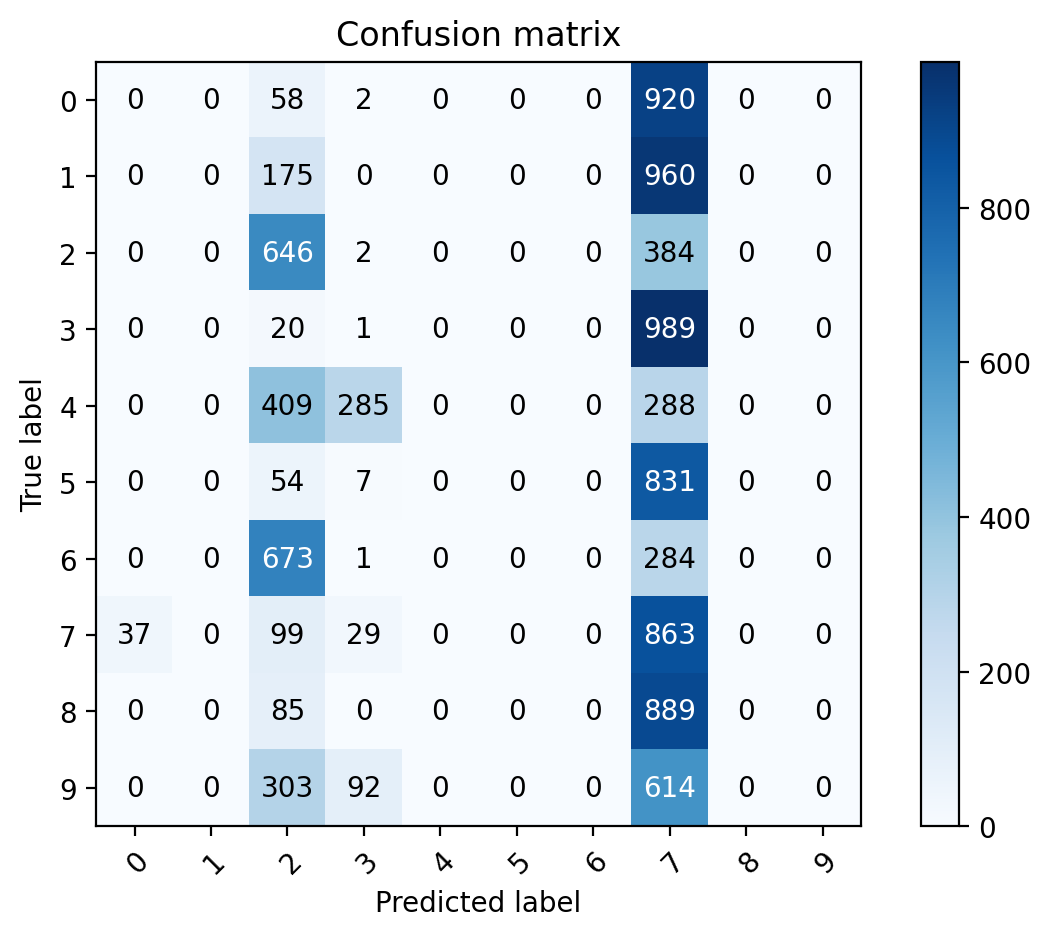

Training 4/5, Epoch 5/5, Train Loss: 15.6263, Test Loss: 15.6392, Test Accuracy: 0.1510
lr=0.071, n_h=8
Training 5/5, Epoch 1/5, Train Loss: 2.3240, Test Loss: 2.3214, Test Accuracy: 0.0774
Training 5/5, Epoch 2/5, Train Loss: 16.9354, Test Loss: 16.8789, Test Accuracy: 0.0837
Training 5/5, Epoch 3/5, Train Loss: 16.5218, Test Loss: 16.4589, Test Accuracy: 0.1065
Training 5/5, Epoch 4/5, Train Loss: 16.5218, Test Loss: 16.4589, Test Accuracy: 0.1065


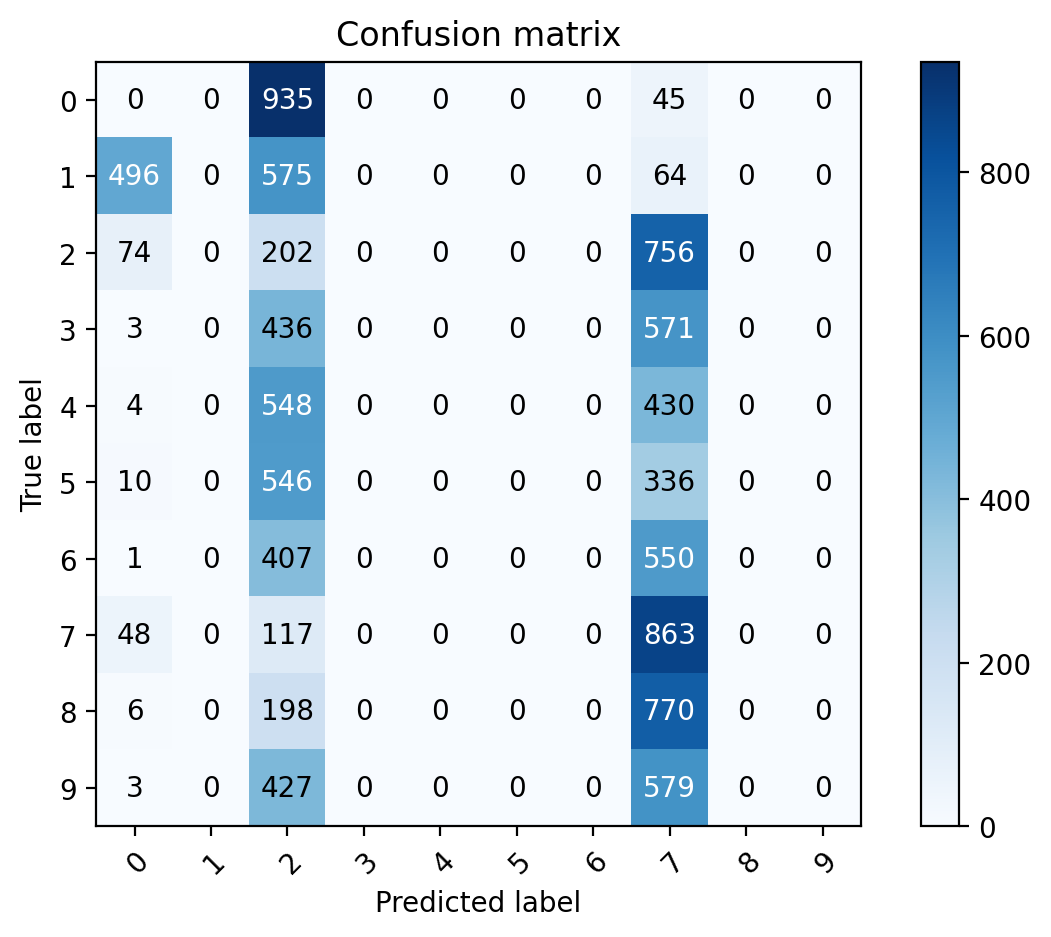

Training 5/5, Epoch 5/5, Train Loss: 16.5218, Test Loss: 16.4589, Test Accuracy: 0.1065


In [70]:
num_trainings=5
epochs=5
labels, train_losses, test_losses, test_accuracies = \
    train_network(num_trainings=num_trainings, epochs=epochs)

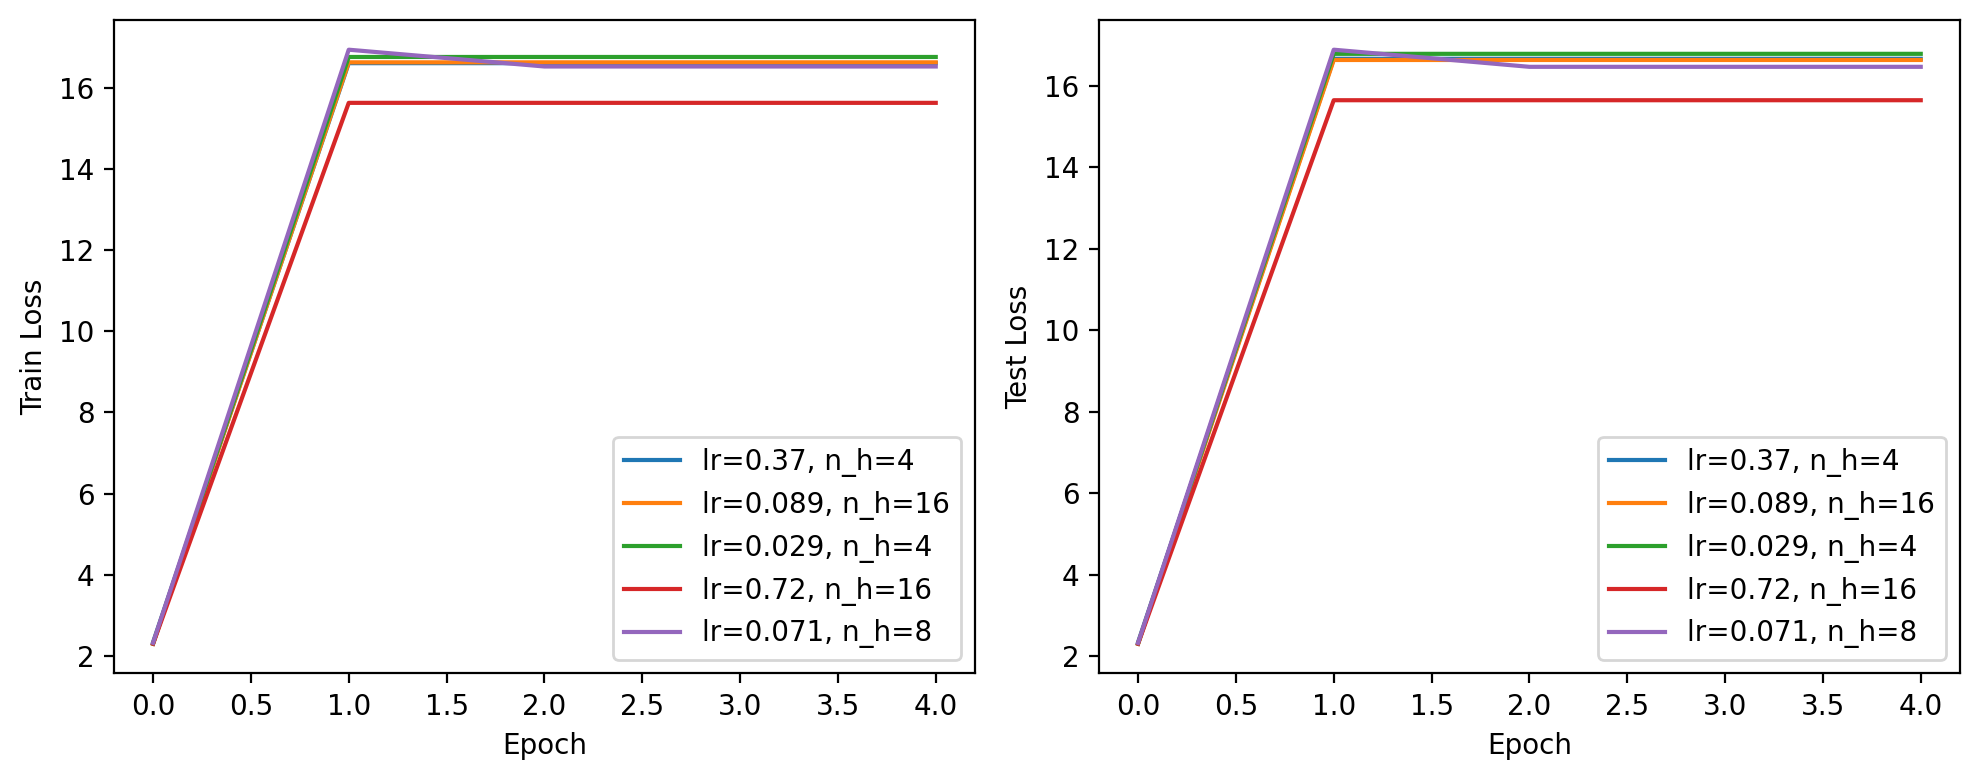

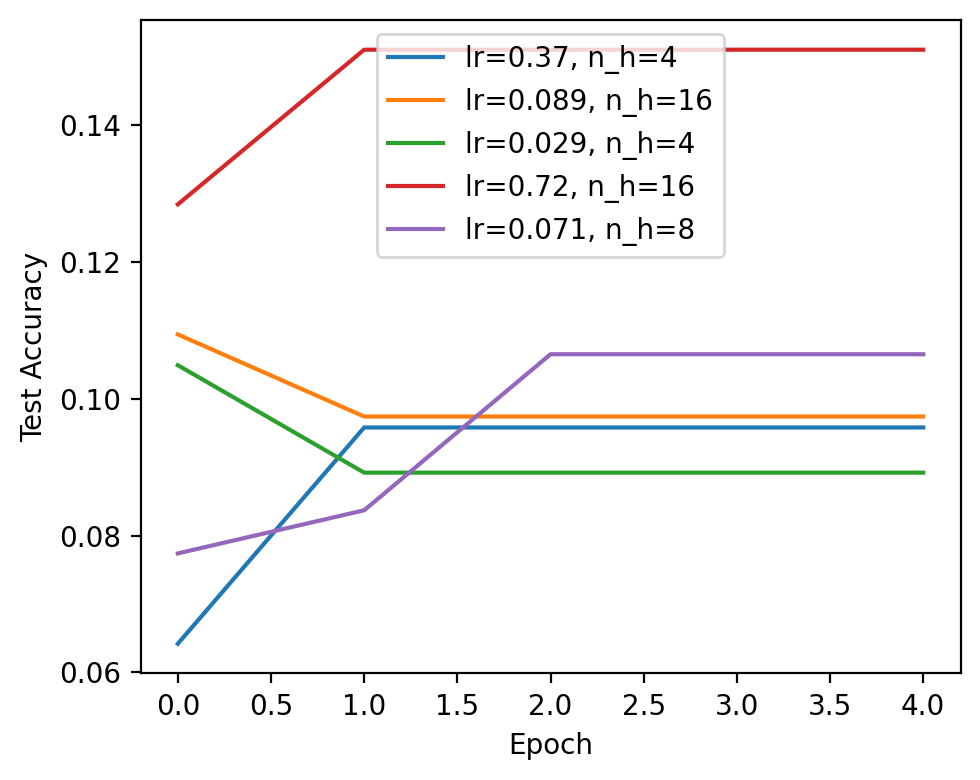

In [71]:
plot_results(labels, train_losses, test_losses, test_accuracies)

**Seemingly independent of the learning rate and the size of the hidden layers, most models maintain an accuracy of around 10%. With 10 classes, this is as good as guessing or constantly giving the same answer. A look at the confusion matrices from the individual runs shows that the models often give the same answer, even though they don’t always settle on the same one.**

To understand this more clearly, we will examine the model's output.

lr=0.031, n_h=16
prediction [[0.06 0.02 0.1  0.11 0.08 0.12 0.15 0.26 0.03 0.07]
 [0.03 0.   0.04 0.08 0.14 0.04 0.16 0.49 0.   0.02]]
Training 1/1, Epoch 1/5, Train Loss: 2.8754, Test Loss: 2.8943, Test Accuracy: 0.1033
prediction [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Training 1/1, Epoch 2/5, Train Loss: 16.6023, Test Loss: 16.6155, Test Accuracy: 0.0980
prediction [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Training 1/1, Epoch 3/5, Train Loss: 16.6023, Test Loss: 16.6155, Test Accuracy: 0.0980
prediction [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Training 1/1, Epoch 4/5, Train Loss: 16.6023, Test Loss: 16.6155, Test Accuracy: 0.0980


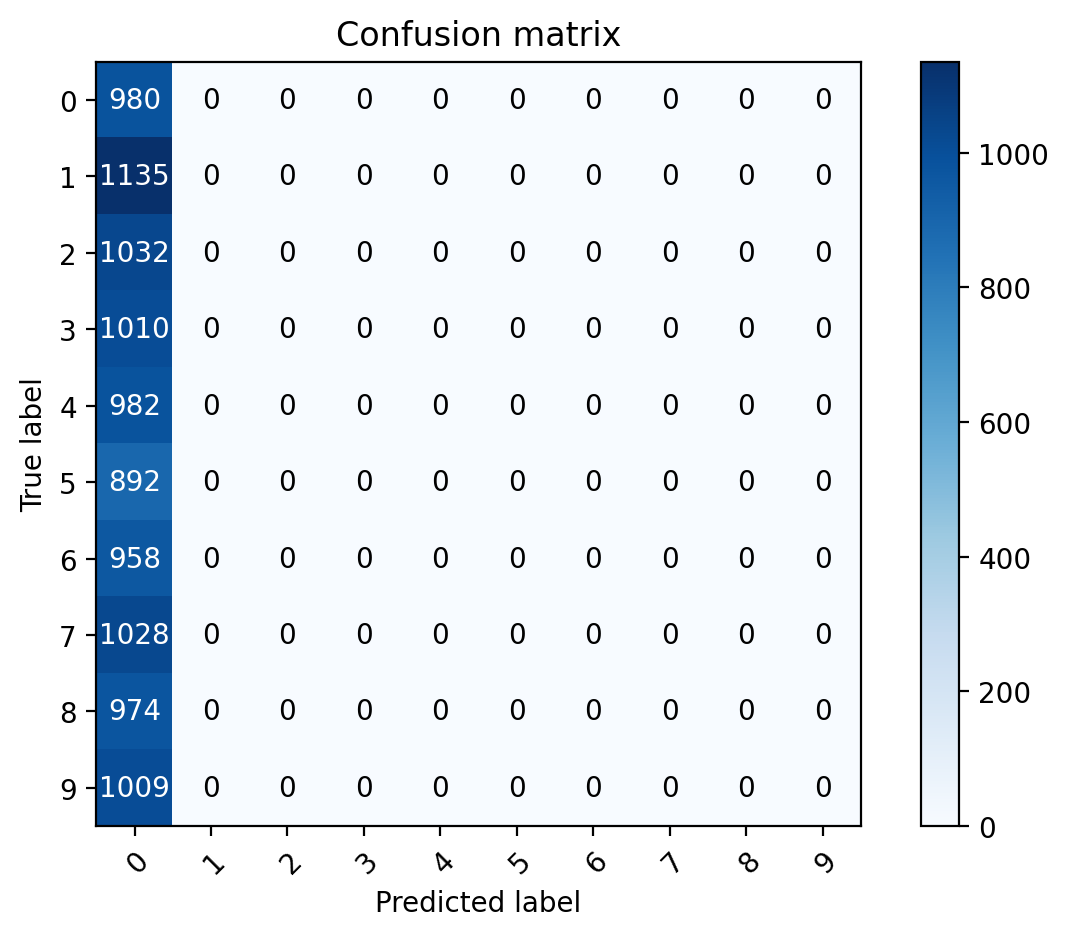

prediction [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Training 1/1, Epoch 5/5, Train Loss: 16.6023, Test Loss: 16.6155, Test Accuracy: 0.0980


In [72]:
num_trainings=1
epochs=5
labels, train_losses, test_losses, test_accuracies = \
    train_network(print_predictions=True, num_trainings=num_trainings, epochs=epochs)

Two cases can be observed:
1. Case: The predictions for the different classes are all roughly the same.
2. Case: The prediction for one particular class becomes (almost) 1, and the others become 0.

In both cases, the class with the highest value is nearly identical for almost all inputs.

##### Explanation:

During training, all data was trained in the same step. The Cross-Entropy Loss works by increasing the probabilities of the correct classes relative to the incorrect ones. Since all classes appear with similar frequency in the dataset, this can lead to all classes being reinforced equally. This may result in the output values for all classes becoming nearly equal, making the output seem independent of the actual input.

In some cases, the model can produce large numerical values in the weights due to taking steps that are too large during training. This can cause one class to take on extreme values, resulting in nearly perfect predictions for that class while ignoring the others.

##### Solution:

The issue can be addressed by splitting the training data into multiple parts (batches) on which the model is trained sequentially. This prevents all classes from being adjusted in exactly the same way at the same time. Instead, the model sees different data in each training step, which helps update the weights in a way that is more diverse and better adapted to different patterns in the dataset. The batch size should be small enough to avoid an overly uniform distribution of classes within a batch, forcing the model to respond more specifically to different patterns.

In addition, batch training speeds up the process by allowing more efficient matrix operations, as smaller datasets can be processed faster. This not only increases the training speed but also improves the model’s generalization ability through more frequent weight updates with varied data.

In [73]:
def train_network(batch_size=32, num_trainings: int=5, epochs: int=5, train_data=None, test_data=None) -> tuple:
    """
    Trains a deep neural network using stochastic gradient descent with cross-entropy loss.

    Args:
    - num_trainings (int): The number of trainings to run. Default: 5.
    - epochs (int): The number of epochs to train each network. Default: 5.
    - train_data: The training data. Default: None.
    - test_data: The test data. Default: None.

    Returns:
    - tuple: A tuple containing the labels, train losses, test losses, and test accuracies for each training run.
    """


    output_size = 10 # NUmber of classes

    train_images, train_labels = preprocess_data(train_data, train_targets)
    test_images, test_labels = preprocess_data(test_data, test_targets)


    all_labels = []
    all_train_losses = []
    all_test_losses = []
    all_test_accuracies = []
    for i in range(num_trainings):
        # Hyperparameters
        hidden_size = np.random.choice([16,32,64])
        learning_rate = 10.**np.random.uniform(-2, 0)
        label = f"lr={learning_rate:.2g}, n_h={hidden_size}"
        print(label)

        # setup model and loss function
        input_size = train_images.shape[1]
        network = DeepNetwork(input_size, hidden_size, output_size)
        loss_function = CrossEntropyLoss()

        # Trainings-Loop
        train_losses = []
        test_losses = []
        test_accuracies = []

        for epoch in range(epochs):

            # compute test loss   do that before training, such that results for an epoch refer to the same state of the model
            test_predictions = network.forward(test_images)
            test_loss = loss_function(test_predictions, test_labels)
            test_losses.append(test_loss)
            if epoch == epochs-1:
                plot_confusion_matrix(test_predictions, test_labels)
            test_predictions = np.argmax(test_predictions, axis=1)  # convert one-hot-encoded predictions to class labels
            test_accuracy = accuracy_score(test_labels, test_predictions)
            test_accuracies.append(test_accuracy)

            train_loss = 0.
            for b in range(train_images.shape[0]//batch_size):
                # Forward-Pass
                predictions = network.forward(train_images[b*batch_size:(b+1)*batch_size])

                # compute train loss
                loss = loss_function(predictions, train_labels[b*batch_size:(b+1)*batch_size])
                train_loss += loss

                # Backward-Pass
                d_outputs = loss_function.derivative()
                network.backward(d_outputs)

                # update parameters (weights and biases)
                network.update(learning_rate)
            train_losses.append(train_loss)

            print(f'Training {i+1}/{num_trainings}, Epoch {epoch + 1}/{epochs}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


        all_labels.append(label)
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)
    return all_labels, all_train_losses, all_test_losses, all_test_accuracies

lr=0.29, n_h=64
Training 1/5, Epoch 1/10, Train Loss: 2.4951, Test Loss: 2.3026, Test Accuracy: 0.1110
Training 1/5, Epoch 2/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 3/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 4/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 5/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 6/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 7/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 8/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
Training 1/5, Epoch 9/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958


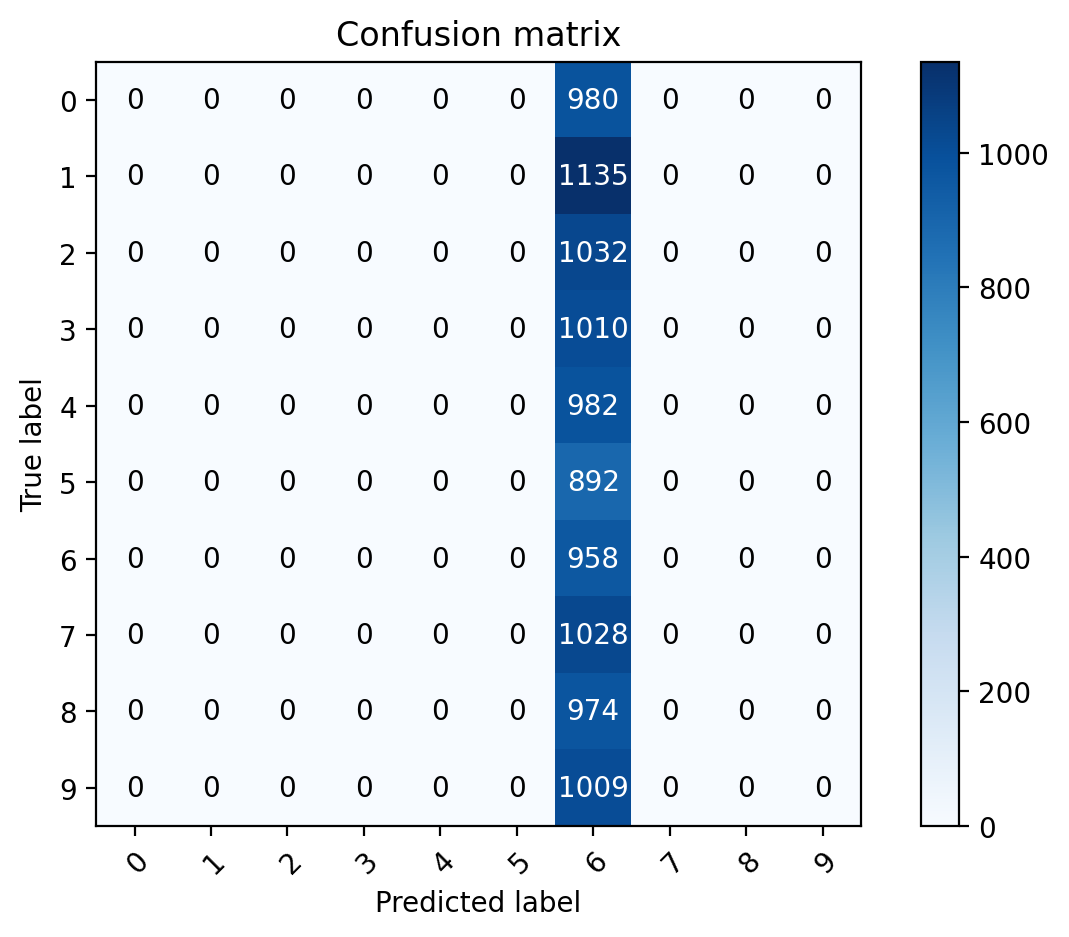

Training 1/5, Epoch 10/10, Train Loss: 2.4951, Test Loss: 2.3540, Test Accuracy: 0.0958
lr=0.016, n_h=64
Training 2/5, Epoch 1/10, Train Loss: 0.0670, Test Loss: 2.3026, Test Accuracy: 0.0901
Training 2/5, Epoch 2/10, Train Loss: 0.0189, Test Loss: 0.1949, Test Accuracy: 0.9454
Training 2/5, Epoch 3/10, Train Loss: 0.0179, Test Loss: 0.1559, Test Accuracy: 0.9584
Training 2/5, Epoch 4/10, Train Loss: 0.0052, Test Loss: 0.1581, Test Accuracy: 0.9603
Training 2/5, Epoch 5/10, Train Loss: 0.0092, Test Loss: 0.1462, Test Accuracy: 0.9623
Training 2/5, Epoch 6/10, Train Loss: 0.0049, Test Loss: 0.1394, Test Accuracy: 0.9664
Training 2/5, Epoch 7/10, Train Loss: 0.0093, Test Loss: 0.1486, Test Accuracy: 0.9643
Training 2/5, Epoch 8/10, Train Loss: 0.0070, Test Loss: 0.1821, Test Accuracy: 0.9557
Training 2/5, Epoch 9/10, Train Loss: 0.0014, Test Loss: 0.1612, Test Accuracy: 0.9639


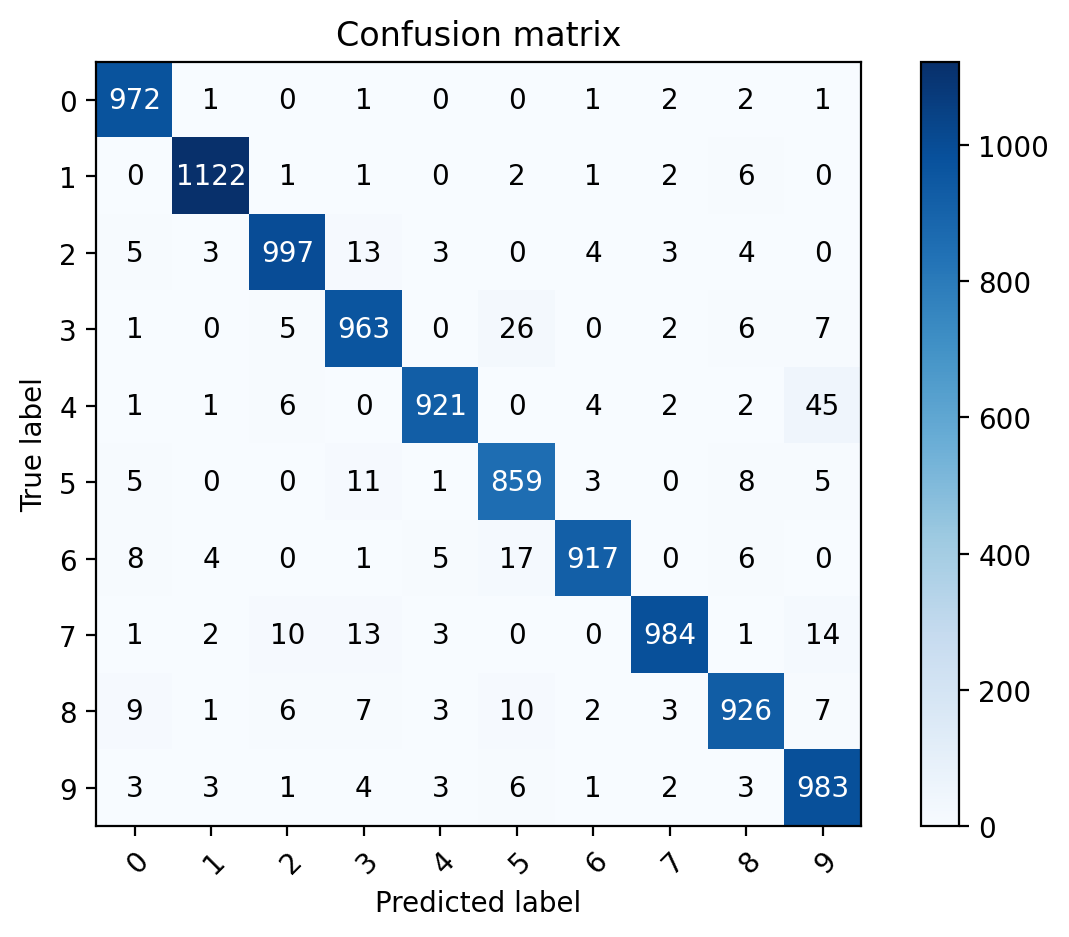

Training 2/5, Epoch 10/10, Train Loss: 0.0007, Test Loss: 0.1613, Test Accuracy: 0.9644
lr=0.1, n_h=16
Training 3/5, Epoch 1/10, Train Loss: 2.3622, Test Loss: 2.3026, Test Accuracy: 0.1236
Training 3/5, Epoch 2/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 3/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 4/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 5/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 6/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 7/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 8/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
Training 3/5, Epoch 9/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958


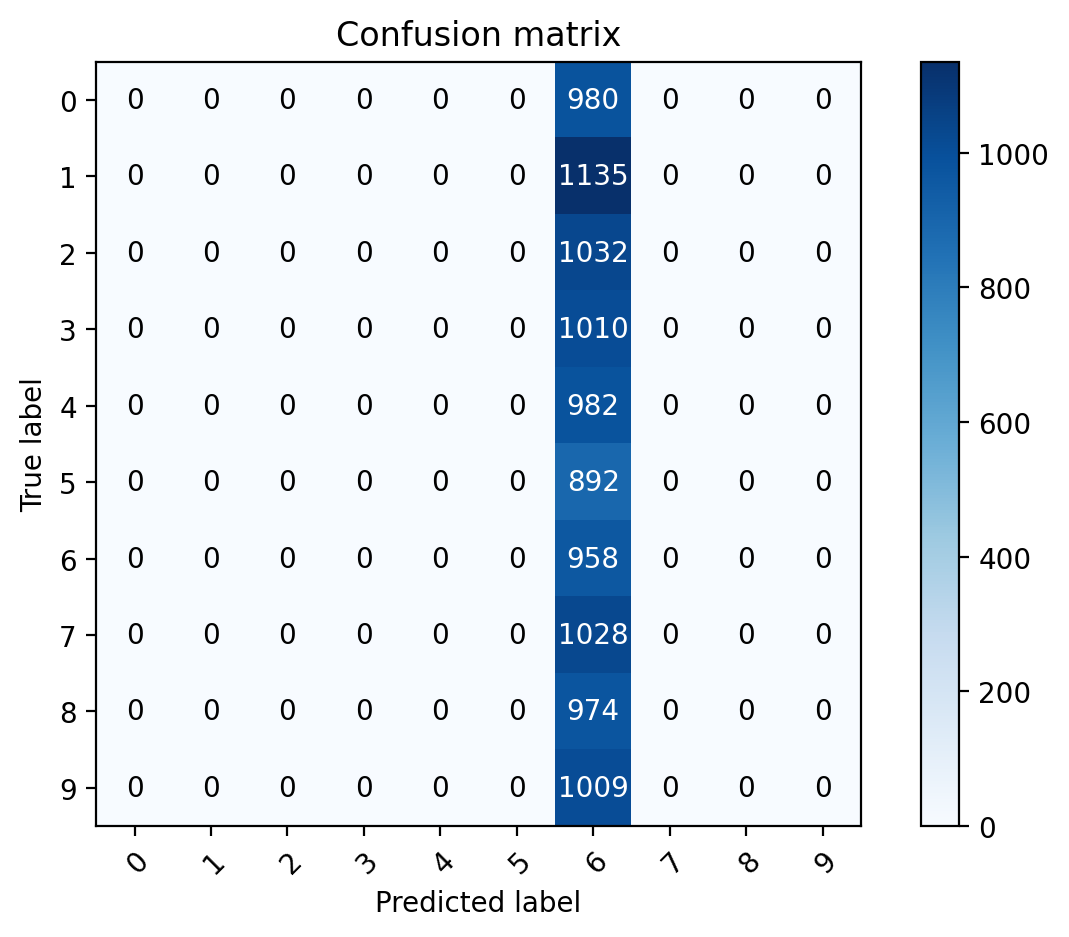

Training 3/5, Epoch 10/10, Train Loss: 2.3622, Test Loss: 2.3068, Test Accuracy: 0.0958
lr=0.031, n_h=32
Training 4/5, Epoch 1/10, Train Loss: 2.3198, Test Loss: 2.3021, Test Accuracy: 0.0956
Training 4/5, Epoch 2/10, Train Loss: 2.3149, Test Loss: 2.3020, Test Accuracy: 0.1135
Training 4/5, Epoch 3/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
Training 4/5, Epoch 4/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
Training 4/5, Epoch 5/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
Training 4/5, Epoch 6/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
Training 4/5, Epoch 7/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
Training 4/5, Epoch 8/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
Training 4/5, Epoch 9/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958


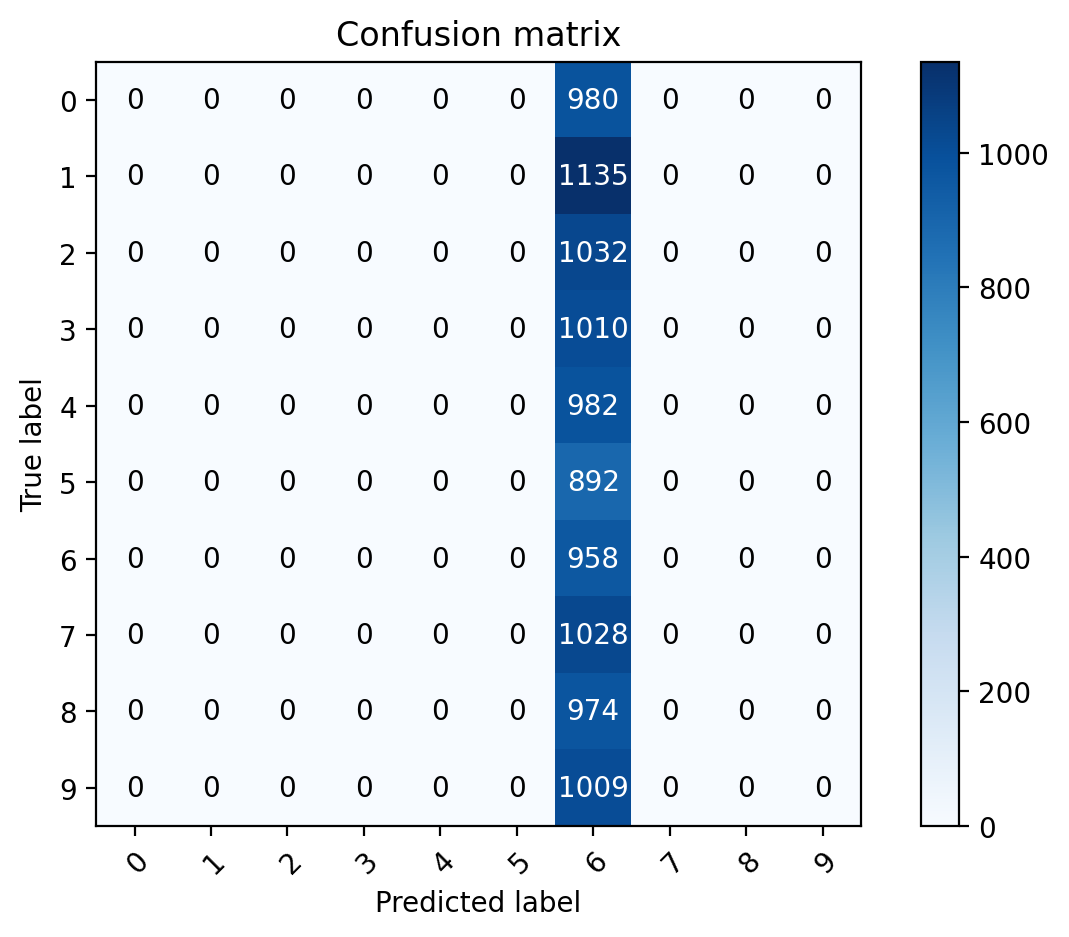

Training 4/5, Epoch 10/10, Train Loss: 2.3149, Test Loss: 2.3023, Test Accuracy: 0.0958
lr=0.019, n_h=32
Training 5/5, Epoch 1/10, Train Loss: 0.1077, Test Loss: 2.3035, Test Accuracy: 0.1074
Training 5/5, Epoch 2/10, Train Loss: 0.0190, Test Loss: 0.3252, Test Accuracy: 0.9160
Training 5/5, Epoch 3/10, Train Loss: 0.0345, Test Loss: 0.3007, Test Accuracy: 0.9226
Training 5/5, Epoch 4/10, Train Loss: 0.0297, Test Loss: 0.2586, Test Accuracy: 0.9343
Training 5/5, Epoch 5/10, Train Loss: 0.0146, Test Loss: 0.2260, Test Accuracy: 0.9449
Training 5/5, Epoch 6/10, Train Loss: 0.0317, Test Loss: 0.2296, Test Accuracy: 0.9429
Training 5/5, Epoch 7/10, Train Loss: 0.0152, Test Loss: 0.2166, Test Accuracy: 0.9472
Training 5/5, Epoch 8/10, Train Loss: 0.0126, Test Loss: 0.2160, Test Accuracy: 0.9479
Training 5/5, Epoch 9/10, Train Loss: 0.0111, Test Loss: 0.2378, Test Accuracy: 0.9439


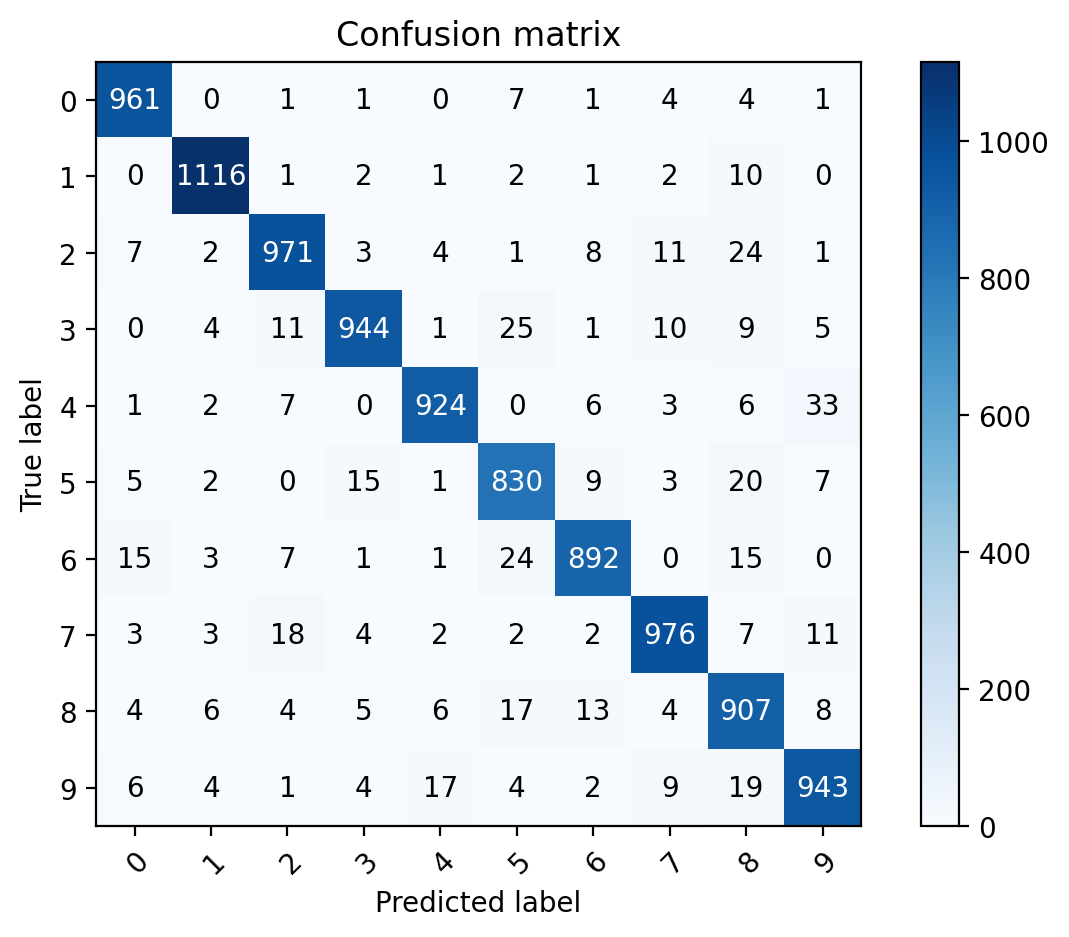

Training 5/5, Epoch 10/10, Train Loss: 0.0158, Test Loss: 0.2257, Test Accuracy: 0.9464


In [74]:
num_trainings=5
epochs=10
labels, train_losses, test_losses, test_accuracies = \
    train_network(num_trainings=num_trainings, epochs=epochs, train_data=train_data, test_data=test_data)

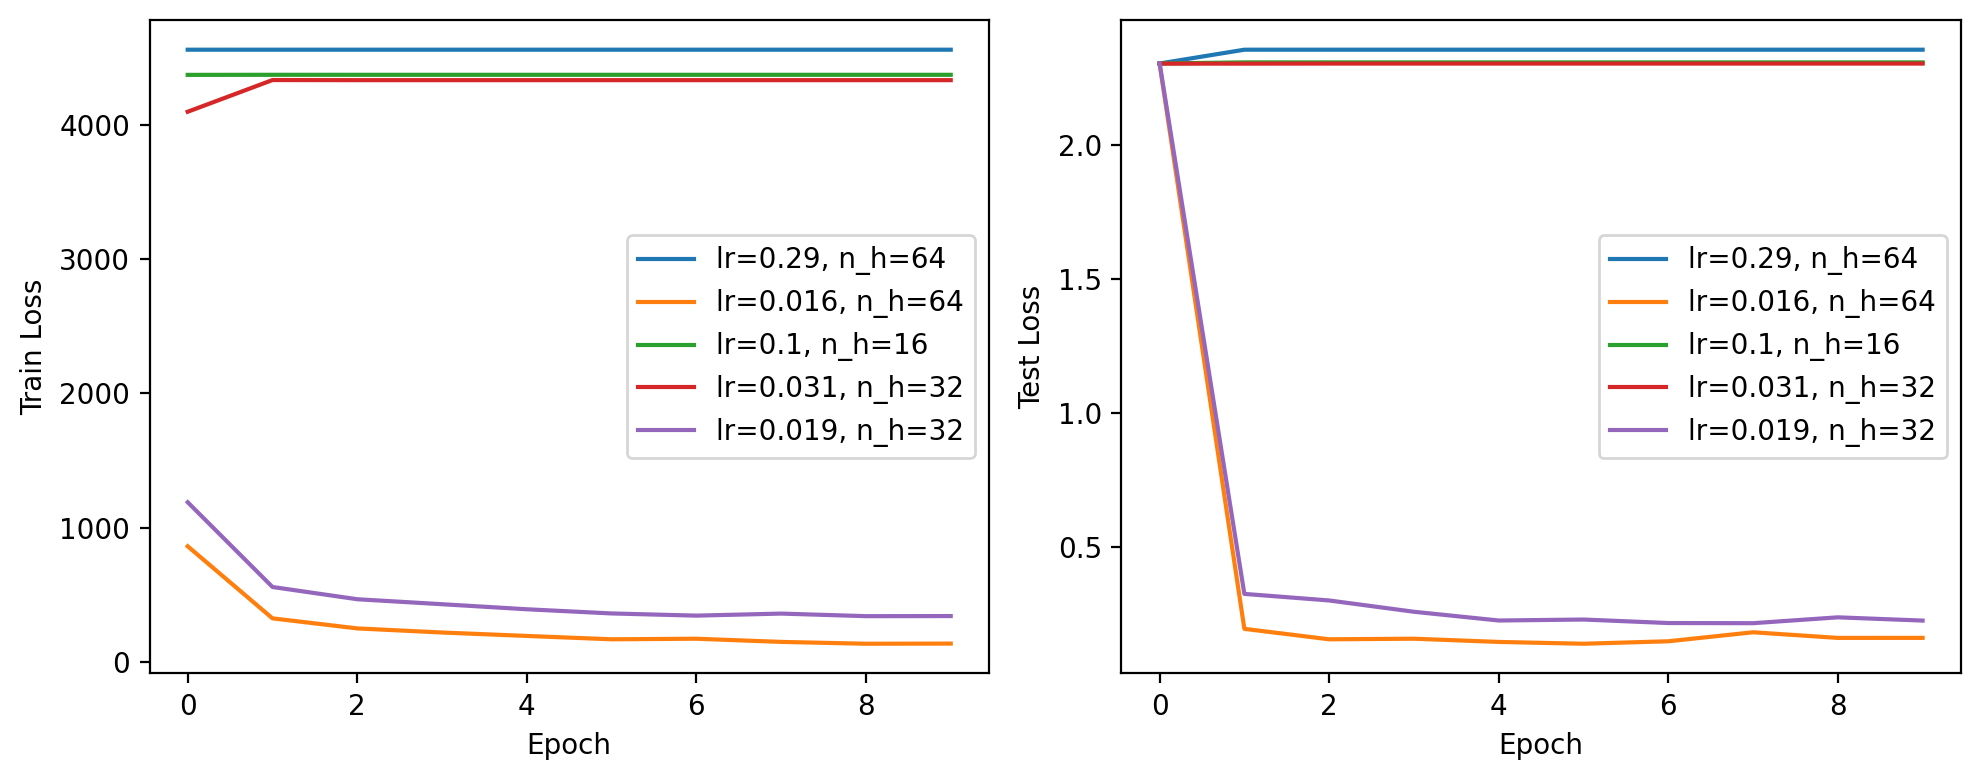

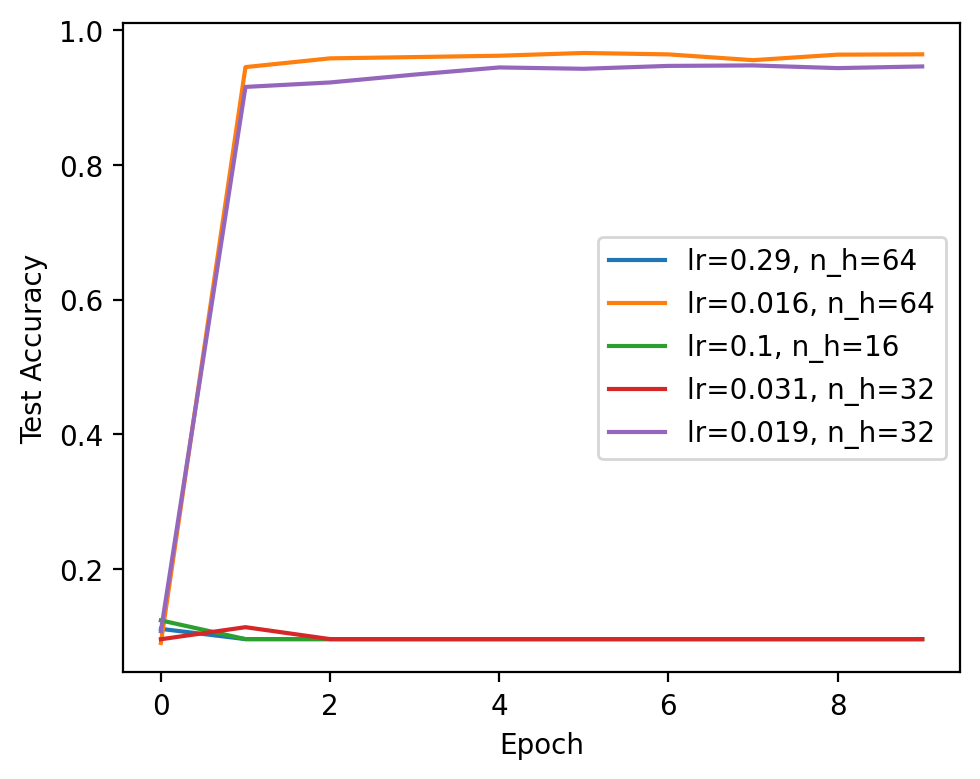

In [75]:
plot_results(labels, train_losses, test_losses, test_accuracies)

With this approach, we achieve good accuracy above 90% in some cases, along with a confusion matrix with a pronounced diagonal, typically when using small learning rates  $\lesssim 0.02$ and large layers. *(If no good run is found, rerun the cell.)*.
**Usually, the best set of hyperparameters shows the fastest and steadiest progression of test accuracy toward the optimum (100%), with both training and test loss decreasing steadily.**
However, the random initialization of weights when creating the network influences the results, as the Cross-Entropy Loss is not convex and has multiple local minima. Therefore, finding the best hyperparameters is challenging and requires a large number of test runs to average out random variations.

Among the many measures to further improve the performance of this network are:
* Improved weight initialization methods
* Regularization to keep the weights small
* Better optimization algorithms to find local minima more quickly
* Activation functions in the hidden layers

Before these measures are implemented to stabilize the network’s training, no definitive decision can be made regarding the appropriate hyperparameters, as each of these measures can significantly affect the network’s behavior and thus the optimal parameters.

## Summary

In this notebook, neural networks were designed and trained to correctly classify the MNIST dataset of handwritten digits. After examining the details of the dataset, a linear layer was implemented as the foundational building block of neural networks. A simple model was then created with one hidden layer and an output layer to identify images containing the digit "4."

During this process, a challenge was encountered due to the fact that only one out of ten images contains a "4." This class imbalance caused the model to learn to never predict a "4." The issue was addressed by applying class weighting or oversampling techniques.

Next, a deeper network with three hidden layers was constructed to classify all digits correctly. An issue arose when training on the entire dataset at once, causing the model to stagnate or degenerate. By dividing the training process into smaller batches, this problem was successfully resolved.

In conclusion, this notebook demonstrates that neural networks can be applied to solve various complex tasks with the same basic structure. However, the optimization required can vary significantly depending on the specific problem. The primary aim of this work was to practice mathematical thinking and communication in practical applications, rather than achieving optimal results. As such, the models presented here are far from reaching an optimal outcome.